# Compare similarity search strategies

In this notebook I am comparing the following similarity search strategies for finding genomic regions with similar peaks:

1. kNN search in the autoencoded latent space
(1b. kNN search in the UMAP 2D embedding of the autoencoded latent space)
2. kNN search in the Euclidean space of the original data
3. kNN search in the DTW space of the original data
4. kNN search in the 2D UMAP embedding of the original data
5. Template-matching with normalized cross correlation

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import json
import h5py
import os
import sys
import warnings

# Ignore warnings as they just pollute the output
warnings.filterwarnings('ignore')

# Enable importing modules from the parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../experiments'))
if module_path not in sys.path:
    sys.path.append(module_path)

# DNase-seq 2011, hg19
bw = 'data/ENCFF158GBQ.bigWig'

## Load and normalize the data

#### Download the data

In [9]:
from download import download_encode_file
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

download_encode_file('ENCFF158GBQ.bigWig')

File already exist. To overwrite pass `overwrite=True`


## Helper methods

#### Simple kNN search

In [45]:
from scipy.spatial.distance import cdist

def knn(data, target_idx, k, metric='euclidean', sax = None, ignore: int = 0):
    """K nearest neighbors
    
    Find the `k` nearest neighbors of a 
    """
    
    target = data[target_idx]
    
    if sax is None:
        dist = cdist(data, target.reshape((1, target.size)), metric='euclidean').flatten()

    else:
        N = data.shape[0]
        dist = np.zeros(N)
        for i in range(N):
            dist[i] = sax.distance_sax(target, data[i])

    # Ensure that the target is always first
    dist[target_idx] = -1
    for i in range(1, ignore + 1):
        dist[min(target_idx + i, data.shape[0] - 1)] = -1
        dist[max(target_idx - i, 0)] = -1
    
    return np.argsort(dist)[1 + (2 * ignore):k + 1 + (2 * ignore)]

#### DTW distance

In [225]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from multiprocessing import Pool

def dtw(data, target_idx: int, n: int, target = None, return_all = False, print_progress: bool = False):
    N = data.shape[0]
    dist = np.zeros(N)
    
    if target is None:
        target = data[target_idx]
        
    p = ((np.arange(4) + 1) * (N // 4)).astype(int)
    
    for i in np.arange(N):
        if i in p and print_progress:
            print('.', end='', flush=True)
        d, _ = fastdtw(data[i], target, dist=euclidean)
        dist[i] = d
    
    if return_all:
        return dist
    
    return np.argsort(dist)[:n]

def pooled_dtw(data, target_idx: int, n: int, target = None, print_progress: bool = False, ignore: int = 0):
    if target is None:
        target = data[target_idx]
    
    with Pool() as pool:
        args = [[d, 0, n, target, True, print_progress] for d in np.array_split(data, pool._processes)]
        dist = np.concatenate(pool.starmap(dtw, args))
        
        # Ensure that the target is always first
        dist[target_idx] = -1
        for i in range(1, ignore + 1):
            dist[min(target_idx + i, data.shape[0] - 1)] = -1
            dist[max(target_idx - i, 0)] = -1
                
        return np.argsort(dist)[1 + (2 * ignore):n + 1 + (2 * ignore)], np.sort(dist)[1 + (2 * ignore):n + 1 + (2 * ignore)]

#### Normalized cross correlation search

In [12]:
from scipy.signal import correlate

def norm(data, zero_norm: bool = False):
    mean = np.mean(data) if zero_norm else 0
    
    return (data - mean) / np.std(data)

def norm2d(data, zero_norm: bool = False):
    mean = np.mean(data, axis=1).reshape(-1, 1) if zero_norm else np.zeros((data.shape[0], 1))
    std = np.std(data, axis=1).reshape(-1, 1)
    
    return (data - mean) / std

def xcorrelation(data, template_idx, n, normalize=False, zero_normalize=False, ignore: int = 0):
    unknown = data
    template = data[template_idx]
    
    if norm:
        unknown = norm2d(unknown, zero_norm=zero_normalize)
        template = norm(template, zero_norm=zero_normalize)
        
    xcorr = np.apply_along_axis(lambda m: correlate(m, template, mode='full'), axis=1, arr=unknown)
    xcorr[np.where(np.isnan(xcorr))] = 0

    max_xcorr = np.nanmax(xcorr, axis=1)
    
    # Ensure that the target is always last
    max_xcorr[template_idx] = -1
    for i in range(1, ignore + 1):
        max_xcorr[min(template_idx + i, data.shape[0] - 1)] = -1
        max_xcorr[max(template_idx - i, 0)] = -1
    
    return np.argsort(max_xcorr)[::-1][:n]

---

# 12 KB Search

In [231]:
k_12kb = 20

In [9]:
from keras.models import load_model
from server import bigwig

# encoder_12kb = load_model('../../examples/encode-gm12878-chip-seq-h3k27ac-pval-2011-encoder-12kb.h5')
# decoder_12kb = load_model('../../examples/encode-gm12878-chip-seq-h3k27ac-pval-2011-decoder-12kb.h5')

data_12kb = bigwig.chunk(
    bw,
    12000,
    100,
    12000 / 6,
    ['chr1'],
    verbose=True,
)

Using TensorFlow backend.


Extracted 124621 windows from chr1 with a max value of 1.0.


In [275]:
from ae.utils import get_models

encoder_12kb, decoder_12kb, autoencoder_12kb = get_models(
    '../../examples/models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---autoencoder-encode-dnase_w-12000_f-2_r-100.h5'
)

In [276]:
from ae.utils import predict

predicted_12kb, _, latent_12kb = predict(
    encoder_12kb,
    decoder_12kb,
    data_12kb.reshape(data_12kb.shape[0], data_12kb.shape[1], 1)
)

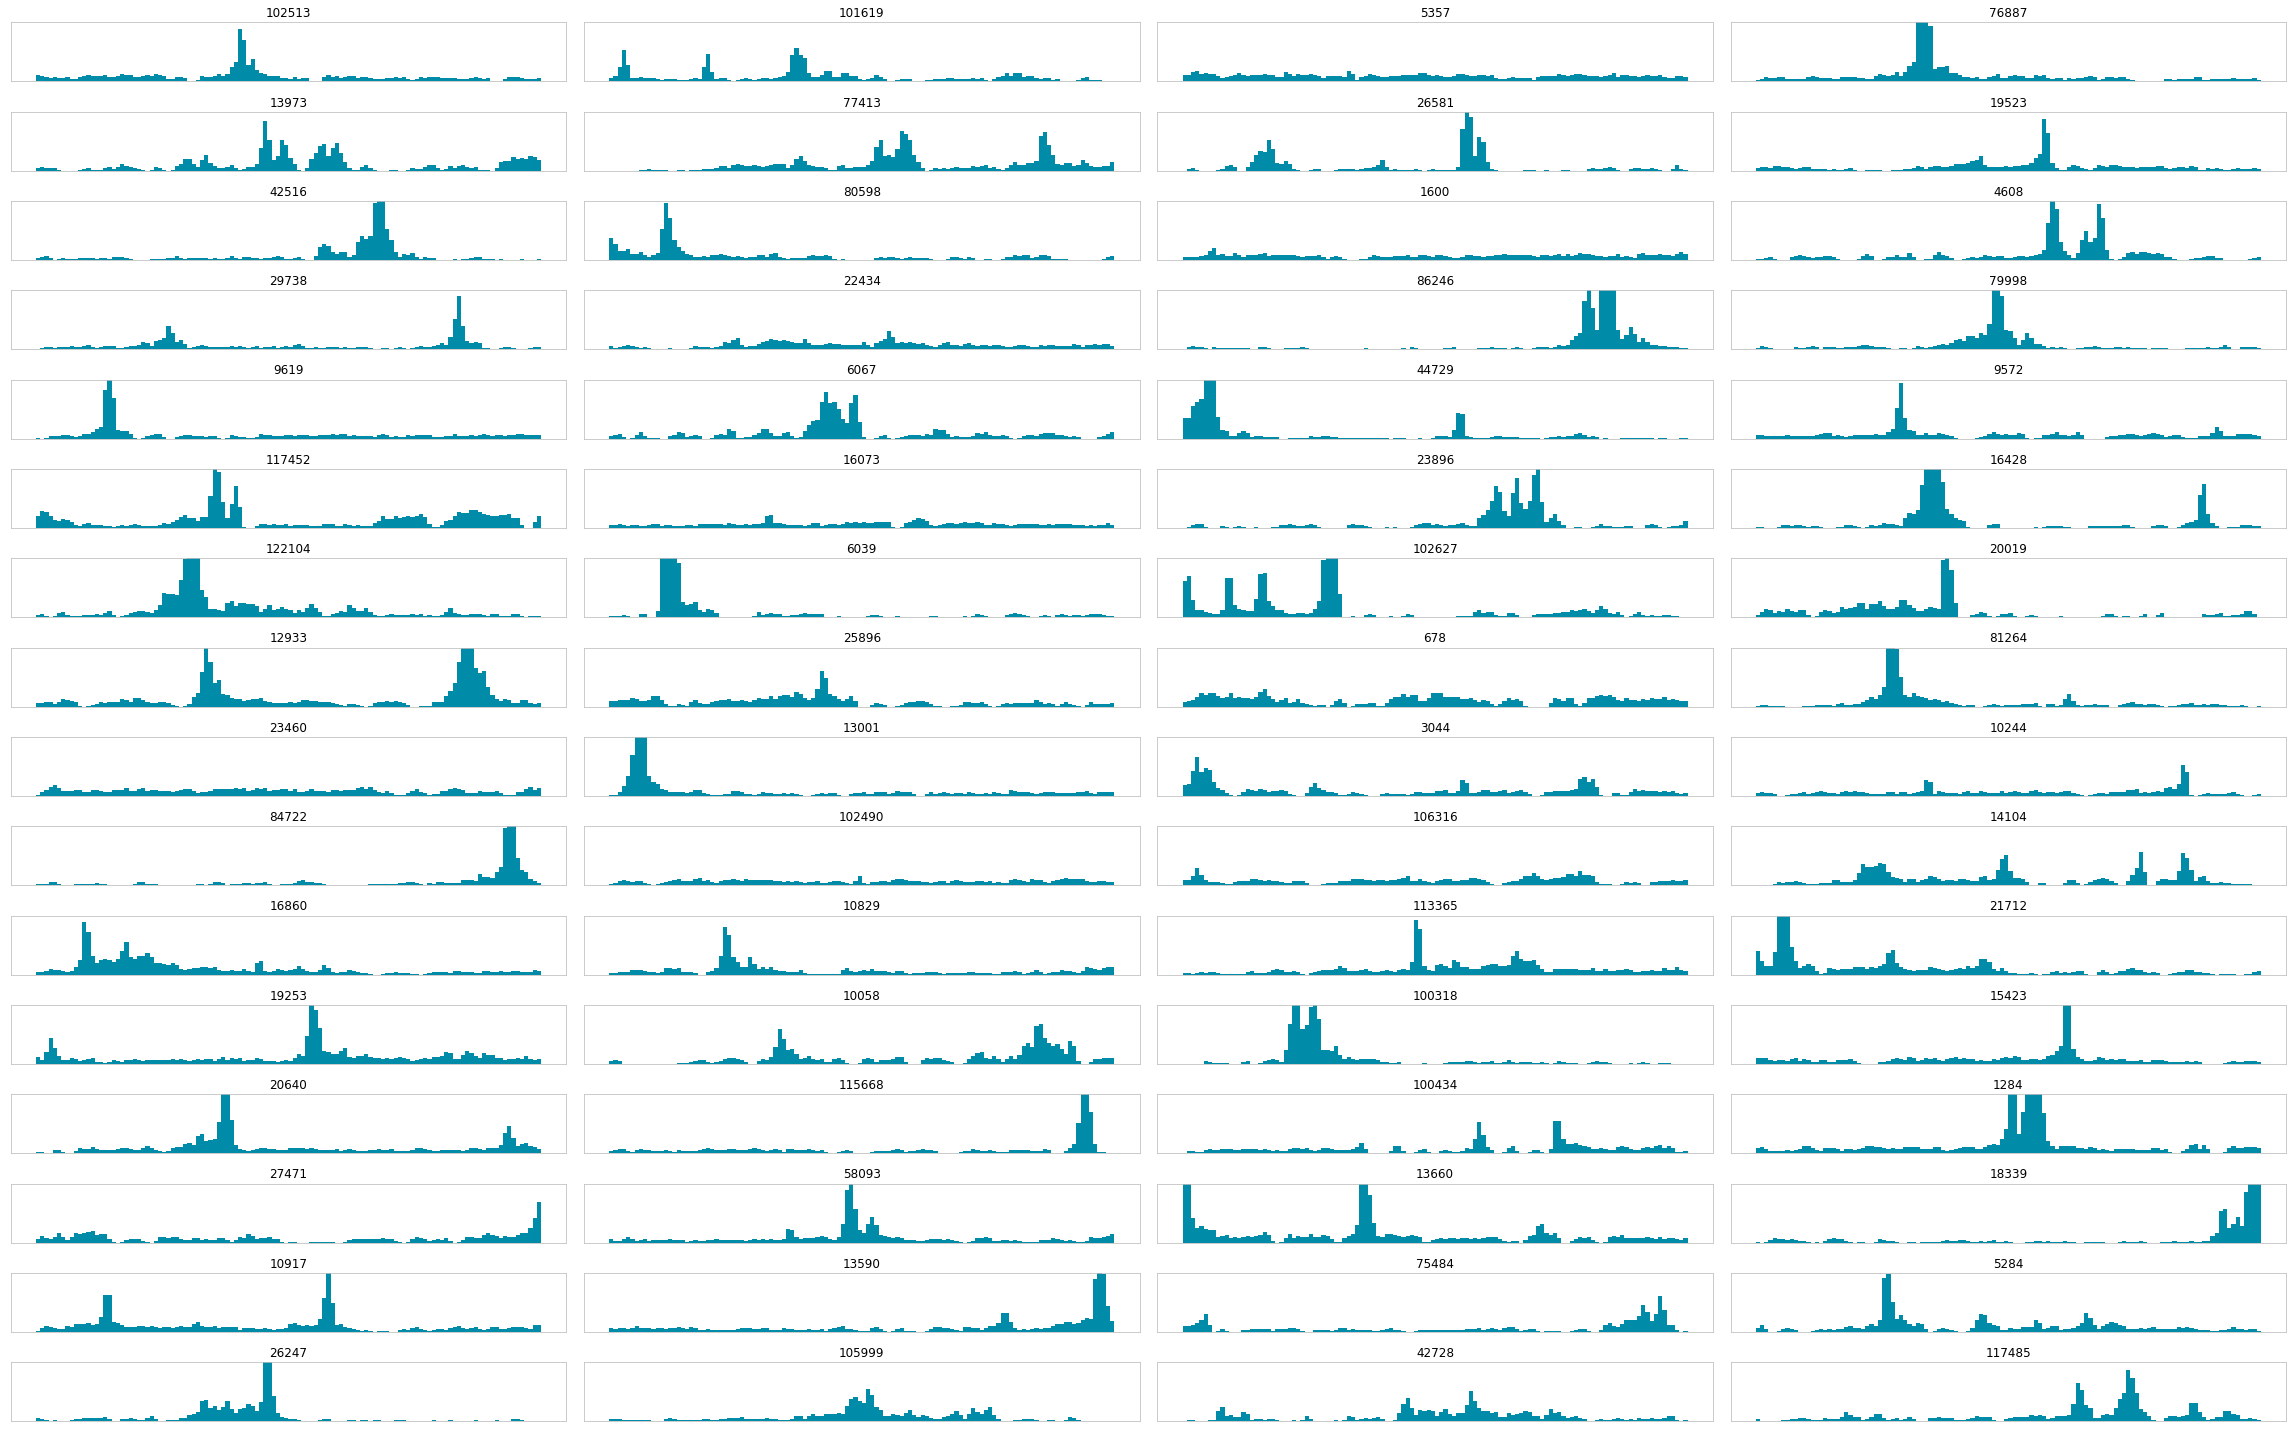

In [178]:
from ae.utils import plot_windows_from_data

num_windows = 64
min_signal = 8

plot_windows_from_data(
    data_12kb,
    num=num_windows,
    min_signal=min_signal,
)

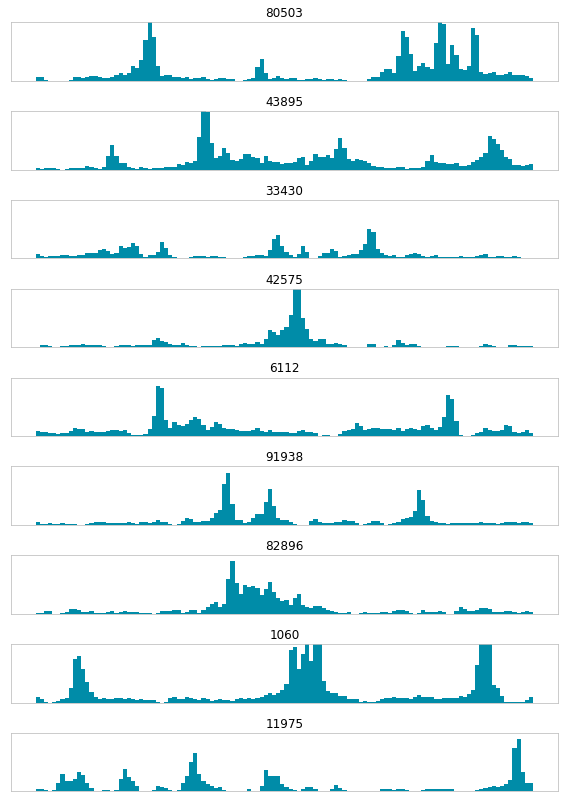

In [15]:
from ae.utils import plot_windows_from_data

targets_12kb = [80503, 43895, 33430, 42575, 6112, 91938, 82896, 1060, 11975]
targets_12kb_ex = 12933

plot_windows_from_data(data_12kb, window_ids=targets_12kb)

In [49]:
import umap

umap_embedding_12kb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
    n_components=10,
).fit_transform(data_12kb)

from tslearn.piecewise import SymbolicAggregateApproximation

sax_12kb = SymbolicAggregateApproximation(n_segments=120, alphabet_size_avg=10)
sax_data_12kb = sax_12kb.fit_transform(data_12kb)

In [ ]:
import h5py
import pandas as pd
from tsfresh import extract_features

N = data_12kb.shape[0]
L = data_12kb.shape[1]

tsfresh_12kb_df = pd.DataFrame(
    np.concatenate(
        (
            np.repeat(np.arange(data_12kb.shape[0]), data_12kb.shape[1]).reshape((-1, 1)),
            data_12kb.reshape((-1, 1)) 
        ),
        axis=1
    ),
    columns=['id', 'value']
)
batch_size = 1000

# with h5py.File('data/tsfresh_12kb.h5', 'w') as f:
#     f.create_dataset('features', shape=(N, 794), dtype=np.float32)
    
#     for i in np.arange(0, N, batch_size):
#         batch = extract_features(
#             tsfresh_12kb_df[i * L:(i + batch_size) * L],
#             column_id='id',
#             n_jobs=4,
#         ).values

#         f['features'][i:i + batch_size] = batch

In [54]:
knn_tsfresh_12kb = []

with h5py.File('data/tsfresh_12kb.h5', 'r') as f:
    tsfresh_12kb = f['features'][:]
    
    # Some features do not seem to computable. Lets set them to zero
    tsfresh_12kb[np.isnan(tsfresh_12kb)] = 0.0
    
#     for target in targets_12kb:
#         knn_tsfresh_12kb.append(knn(tsfresh_12kb, target, k_12kb))

In [55]:
from time import time

# Some genomic windows with interesting peaks
targets_12kb = [80503, 43895, 33430, 42575, 6112, 91938, 82896, 1060, 11975]
k_12kb = 20

# with h5py.File('data/12kb-similarity-search.h5', 'w') as f:
    f.create_dataset('knn_ae', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_eq', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_sax', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_dtw', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_umap', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_tsfresh', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('top_xcorr', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    
    for i, target in enumerate(targets_12kb):
        t0 = time()
        print('Search for window #{}'.format(target), end='', flush=True)
        f['knn_ae'][i] = knn(latent_12kb, target, k_12kb, ignore=2)
        print('.', end='', flush=True)
        f['knn_eq'][i] = knn(data_12kb, target, k_12kb, ignore=2)
        print('.', end='', flush=True)
        f['knn_sax'][i] = knn(sax_data_12kb, target, k_12kb, sax=sax_12kb, ignore=2)
        print('.', end='', flush=True)
        f['knn_umap'][i] = knn(umap_embedding_12kb, target, k_12kb, ignore=2)
        print('.', end='', flush=True)
        f['top_xcorr'][i] = xcorrelation(data_12kb, target, k_12kb, normalize=True, zero_normalize=True, ignore=2)
        print('.', end='', flush=True)
        f['knn_tsfresh'][i] = knn(tsfresh_12kb, target, k_12kb)
        print('.', end='', flush=True)
        f['knn_dtw'][i] = pooled_dtw(data_12kb, target, k_12kb, ignore=2)
        print('. done! ({:.2f} sec)'.format(time() - t0))

Search for window #80503....... done! (1428.24 sec)
Search for window #43895....... done! (1470.52 sec)
Search for window #33430....... done! (1379.04 sec)
Search for window #42575....... done! (1343.98 sec)
Search for window #6112....... done! (1407.73 sec)
Search for window #91938....... done! (3040.62 sec)
Search for window #82896....... done! (1595.27 sec)
Search for window #1060....... done! (1545.69 sec)
Search for window #11975....... done! (1590.07 sec)


In [5]:
import h5py
    
with h5py.File('data/12kb-similarity-search.h5', 'r') as f:    
    knn_ae_12kb = f['knn_ae'][:]
    knn_eq_12kb = f['knn_eq'][:]
    knn_sax_12kb = f['knn_sax'][:]
    knn_dtw_12kb = f['knn_dtw'][:]
    knn_umap_12kb = f['knn_umap'][:]
    knn_tsfresh_12kb = f['knn_tsfresh'][:]
    top_xcorr_12kb = f['top_xcorr'][:]

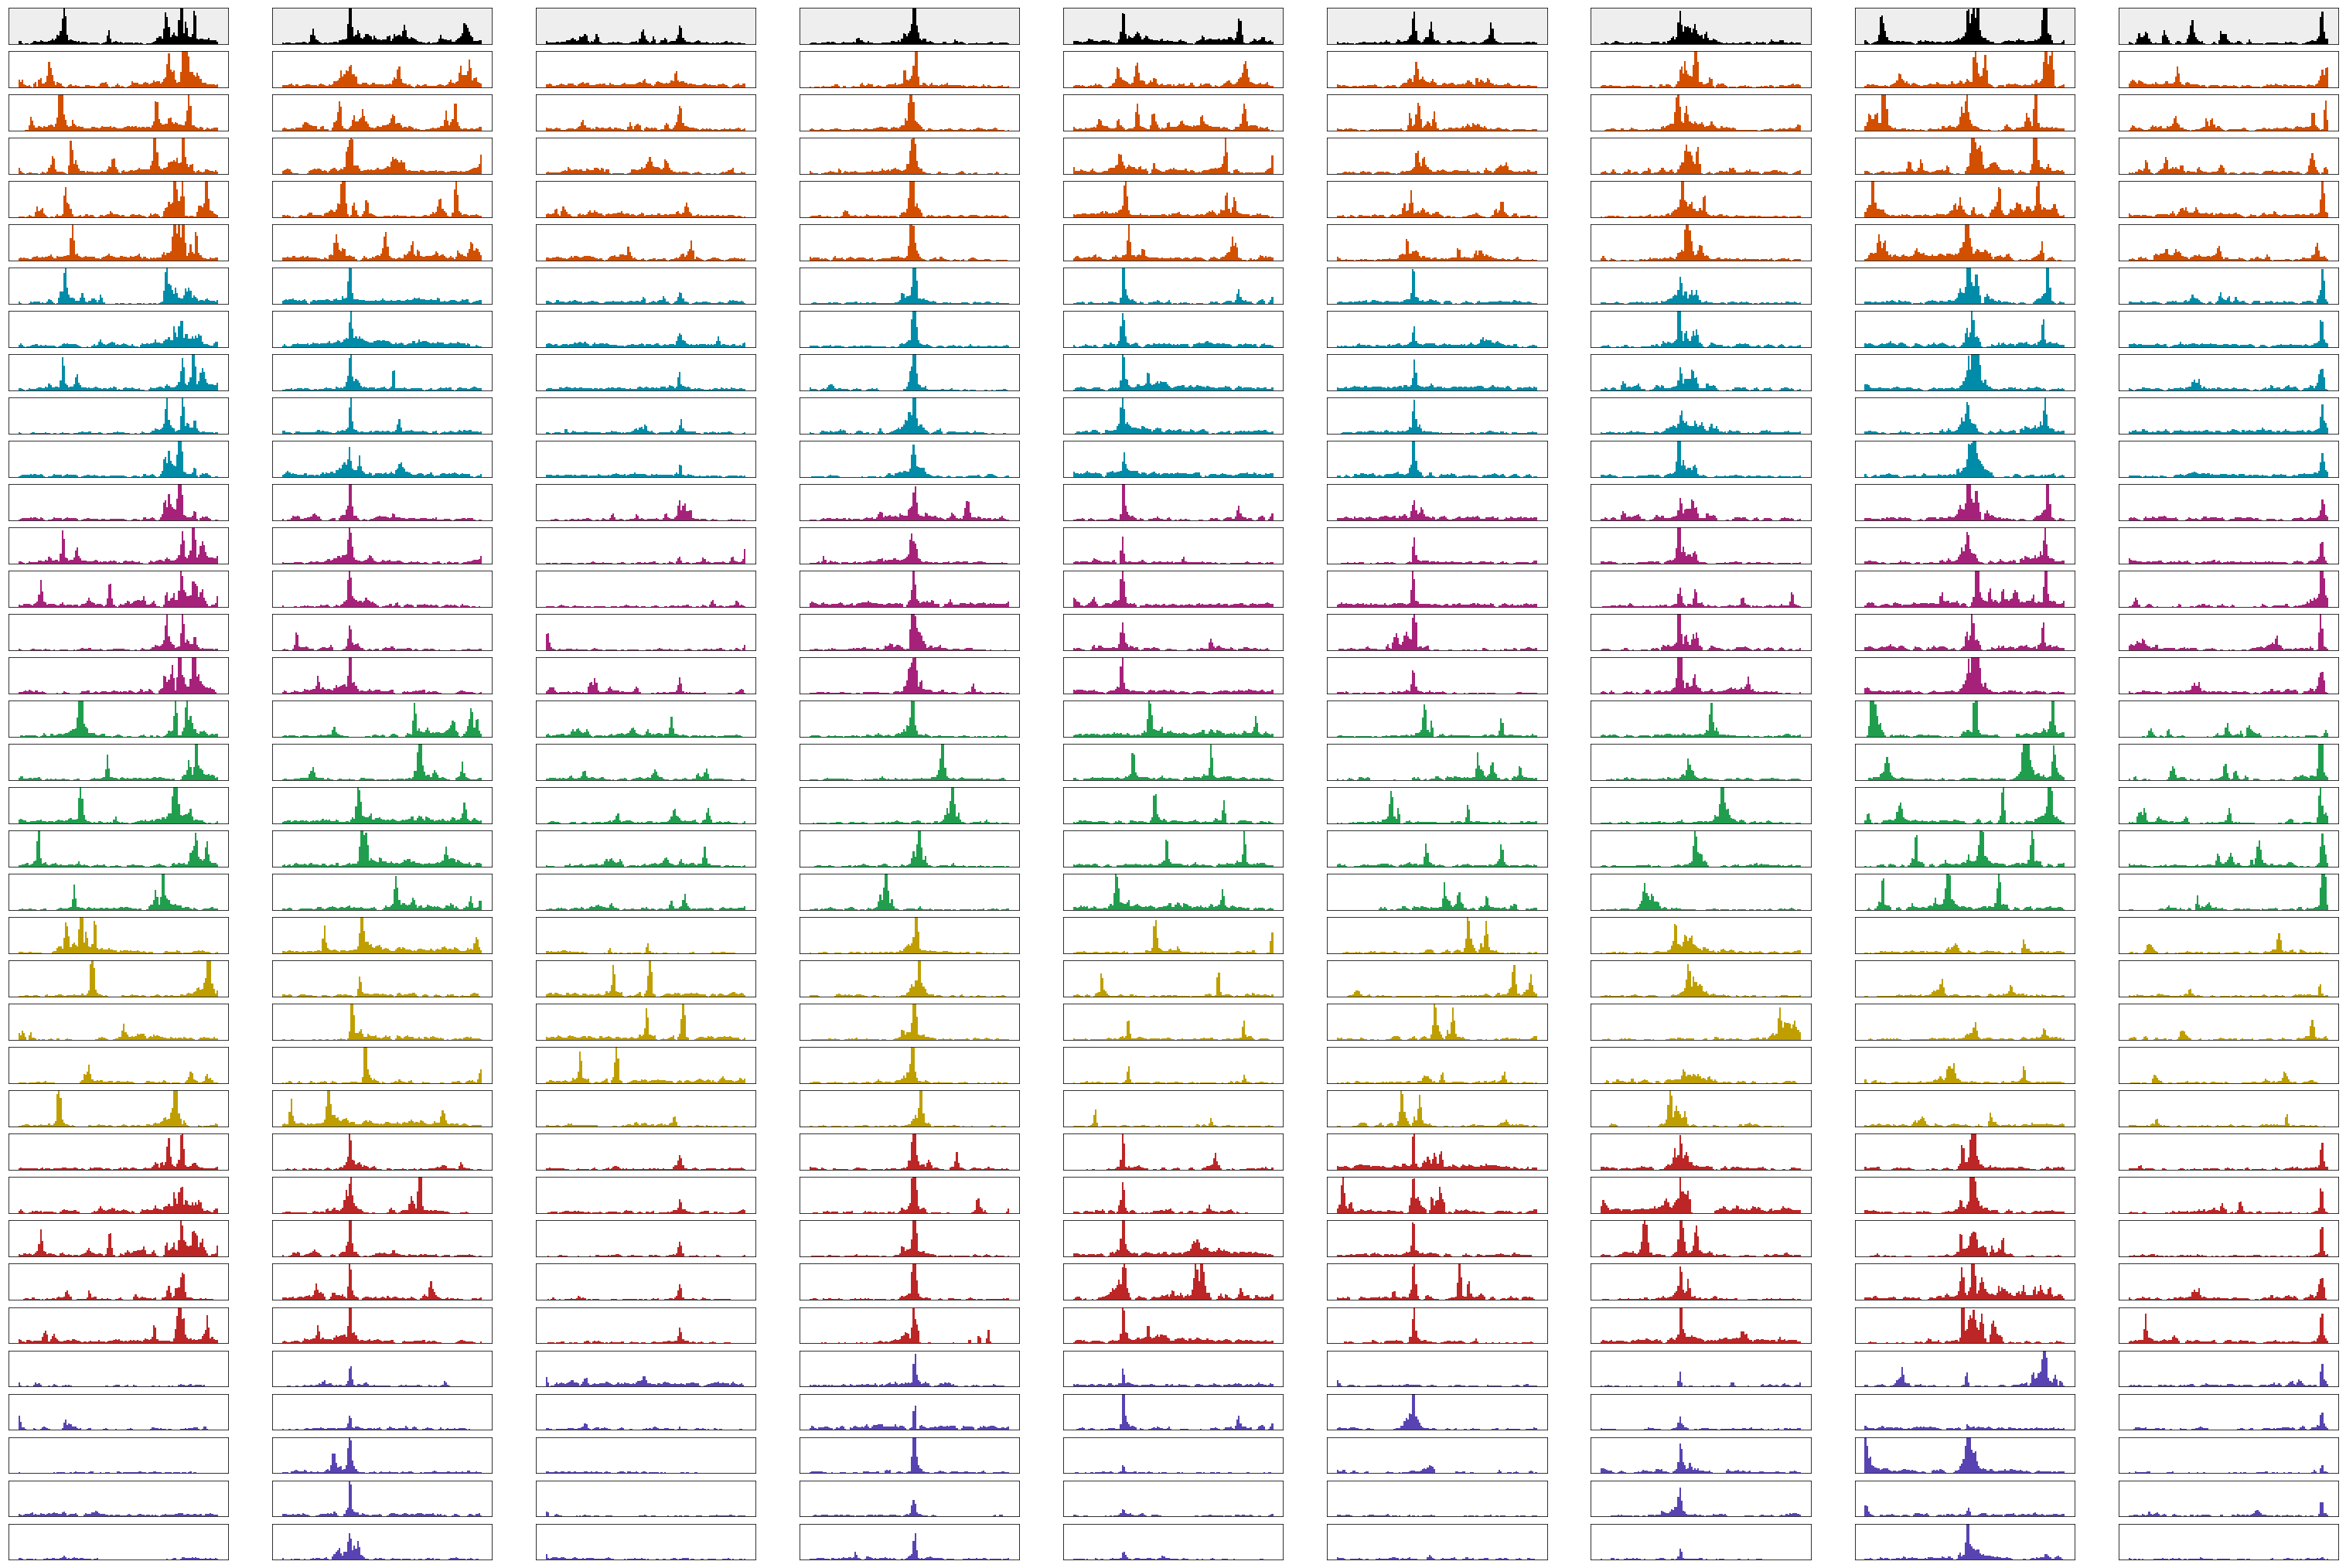

In [299]:
import matplotlib.pyplot as plt 
import numpy as np
import json

show = 5

N = (show + 1) * 7

T = len(targets_12kb)
sz = data_12kb[0].size

plt.figure(figsize=(6 * T, N))

ymax = 1.0

show_predictions = False

for i, target in enumerate(targets_12kb):
    ax = plt.subplot(N, T, (i + 1))
        
    ax.set_facecolor("#eeeeee")
    
    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_ae_12kb_new[i][:show]):
        plt.subplot(N, T, ((j + 1) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#d24f00', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(knn_eq_12kb[i][:show]):
        plt.subplot(N, T, ((j + 6) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#008ca8', width=1.0) # blue = EQ
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_sax_12kb[i][:show]):
        plt.subplot(N, T, ((j + 11) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#a6227a', width=1.0) # purple = SAX
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_dtw_12kb[i][:show]):
        plt.subplot(N, T, ((j + 16) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#209e4e', width=1.0) # green = DTW
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(top_xcorr_12kb[i][:show]):
        plt.subplot(N, T, ((j + 21) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#bf9f00', width=1.0) # yellow = Zero-nornalized X correlation
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_umap_12kb[i][:show]):
        plt.subplot(N, T, ((j + 26) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#bc2626', width=1.0) # red = UMAP
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_tsfresh_12kb[i][:show]):
        plt.subplot(N, T, ((j + 31) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#5943b2', width=1.0) # purple = tsfresh
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

---
---
---

# 120 kb search

In [10]:
from ae.utils import get_models
from server import bigwig

bw = 'data/ENCFF158GBQ.bigWig'
chroms = ['chr22', 'chr1']

encoder_120kb, decoder_120kb, autoencoder_120kb = get_models(
    '../../examples/models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---autoencoder-encode-dnase_w-120000_f-6_r-1000.h5'
)

data_120kb = bigwig.chunk(
    bw,
    120000,
    1000,
    120000 / 4,
    ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
    verbose=True,
)

Extracted 8306 windows from chr1 with a max value of 1.0.
Extracted 8104 windows from chr2 with a max value of 0.9999999999999999.
Extracted 6598 windows from chr3 with a max value of 1.0.
Extracted 6369 windows from chr4 with a max value of 1.0.
Extracted 6028 windows from chr5 with a max value of 1.0.
Extracted 5701 windows from chr6 with a max value of 1.0.
Extracted 5302 windows from chr7 with a max value of 0.9999999999999999.
Extracted 4876 windows from chr8 with a max value of 1.0.
Extracted 4705 windows from chr9 with a max value of 1.0.
Extracted 4515 windows from chr10 with a max value of 1.0.
Extracted 4498 windows from chr11 with a max value of 1.0.
Extracted 4459 windows from chr12 with a max value of 1.0.
Extracted 3836 windows from chr13 with a max value of 1.0.
Extracted 3576 windows from chr14 with a max value of 1.0.
Extracted 3415 windows from chr15 with a max value of 1.0.
Extracted 3009 windows from chr16 with a max value of 1.0.
Extracted 2704 windows from chr17 w

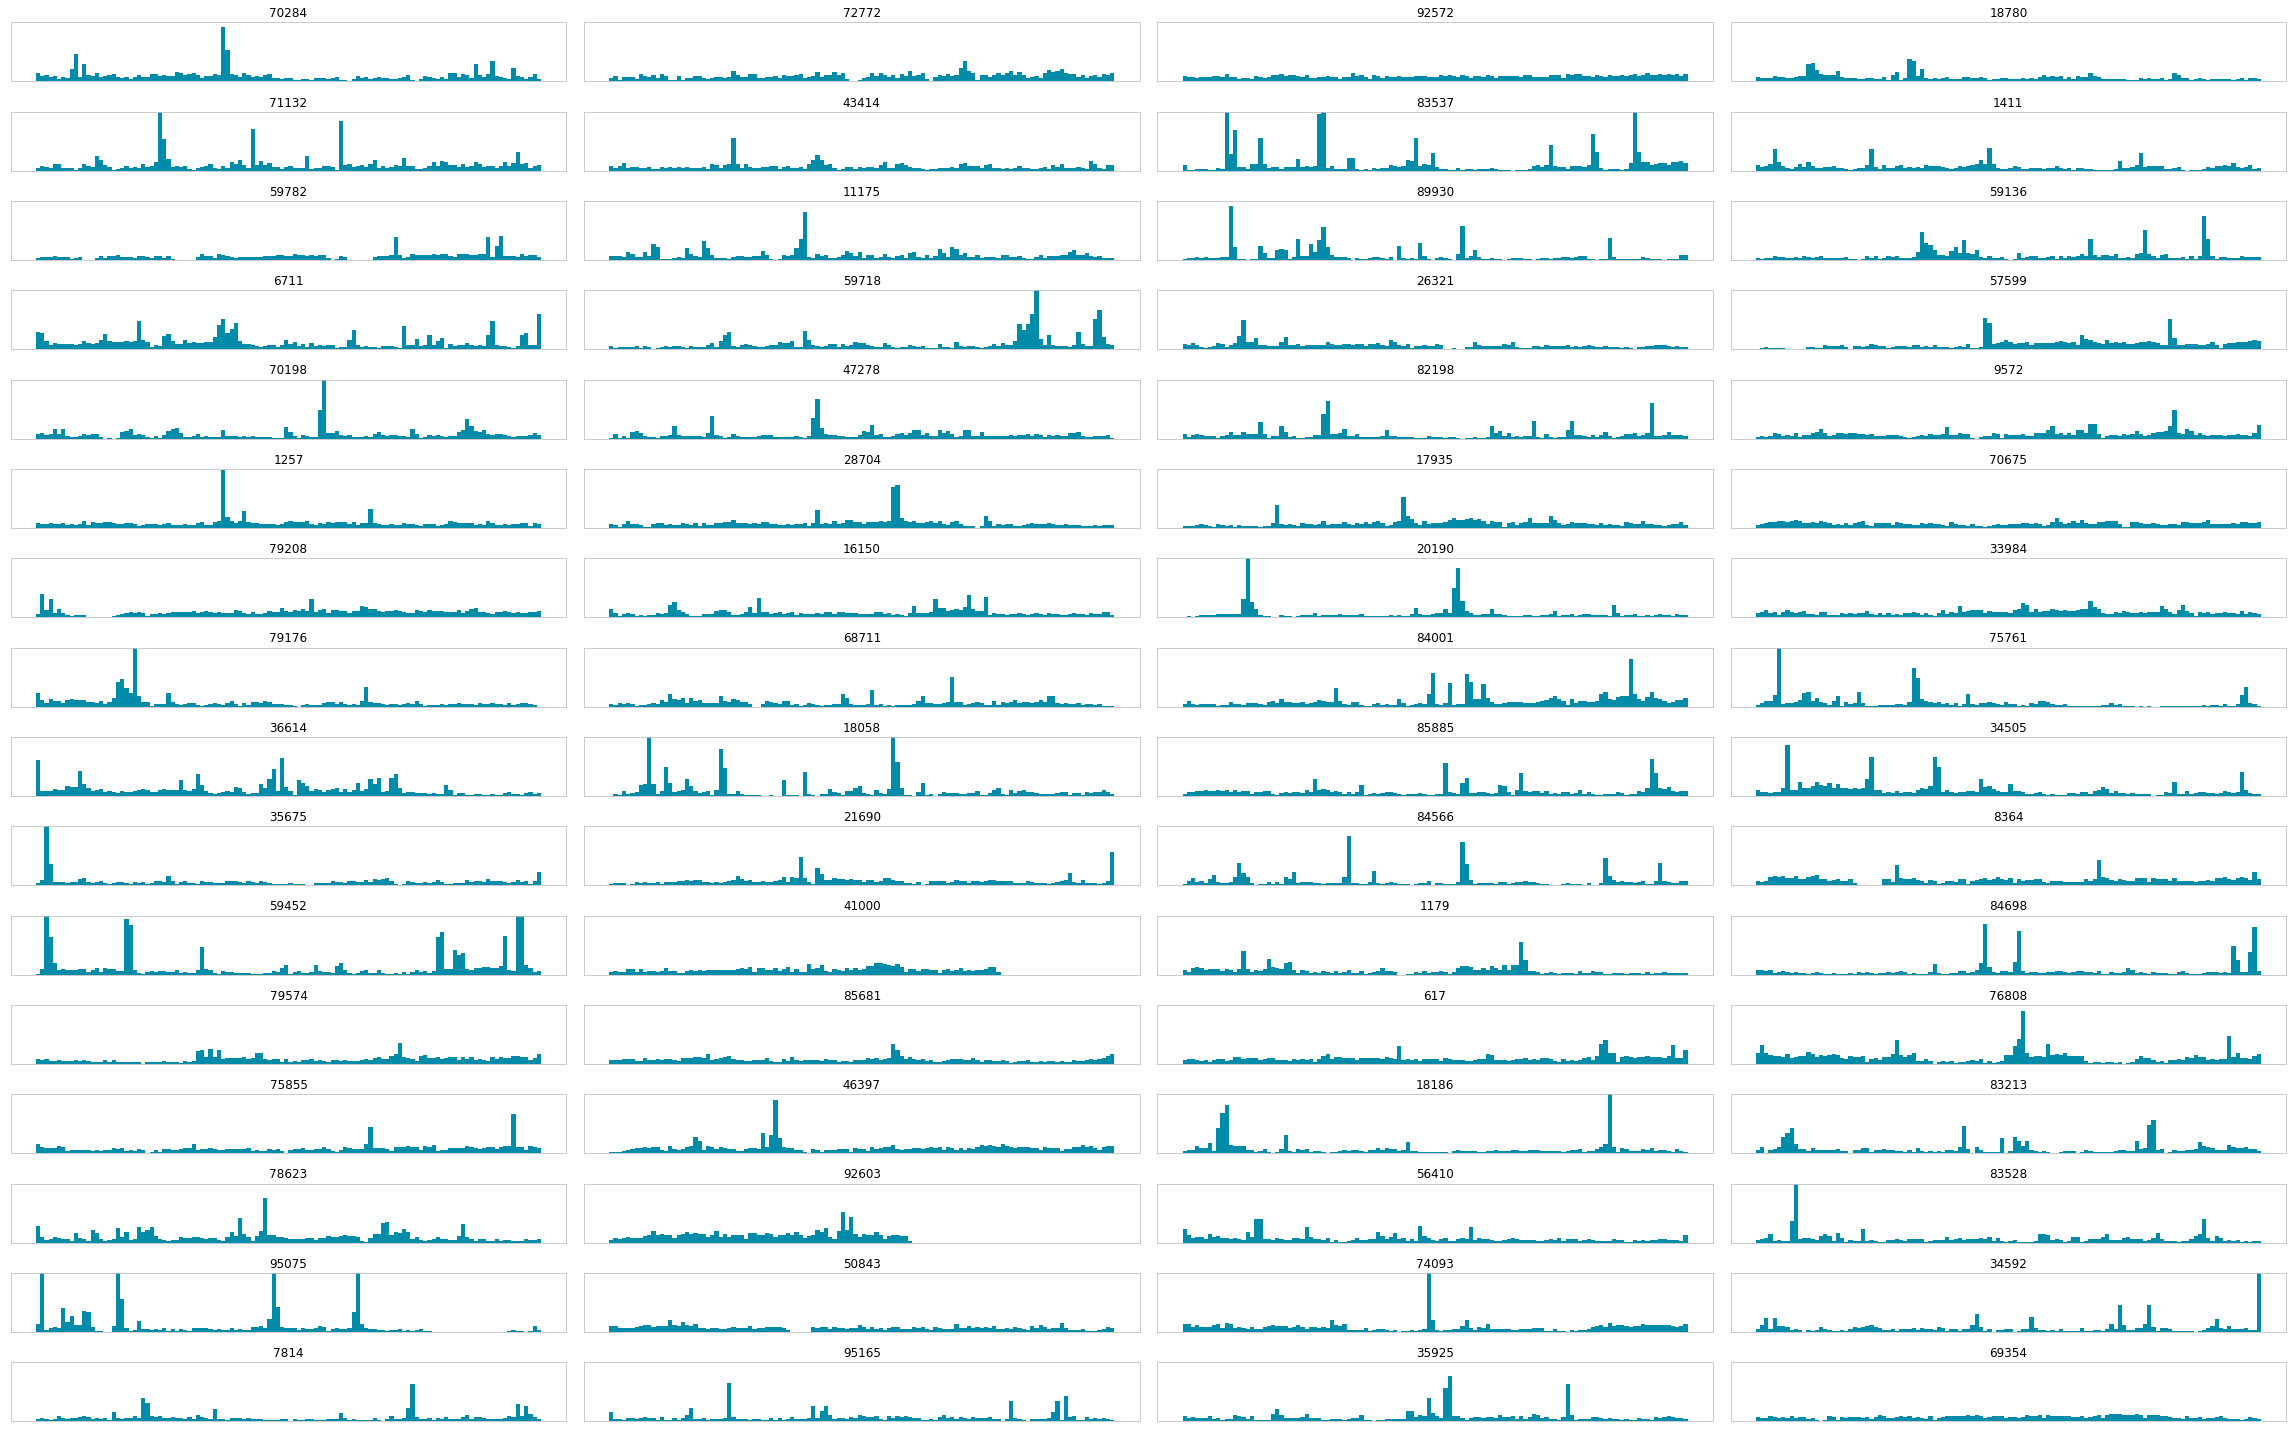

In [367]:
from ae.utils import plot_windows_from_data

plot_windows_from_data(
    data_120kb,
    num=64,
    min_signal=8,
    max_signal=16,
)

In [48]:
# Lets store 20 but display only 5 later on
k_120kb = 20
targets_120kb = [58494, 60529, 34033, 31102, 19785, 69049, 88580, 59132, 53716]
targets_120kb_ex = 18186

In [49]:
knn_ae_120kb_ex = knn(latent_120kb, targets_120kb_ex, 5, ignore=1)

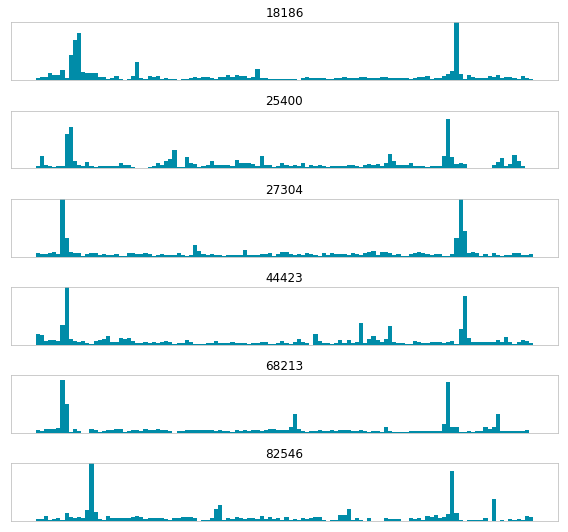

In [50]:
plot_windows_from_data(data_120kb, window_ids=[targets_120kb_ex] + knn_ae_120kb_ex.tolist())

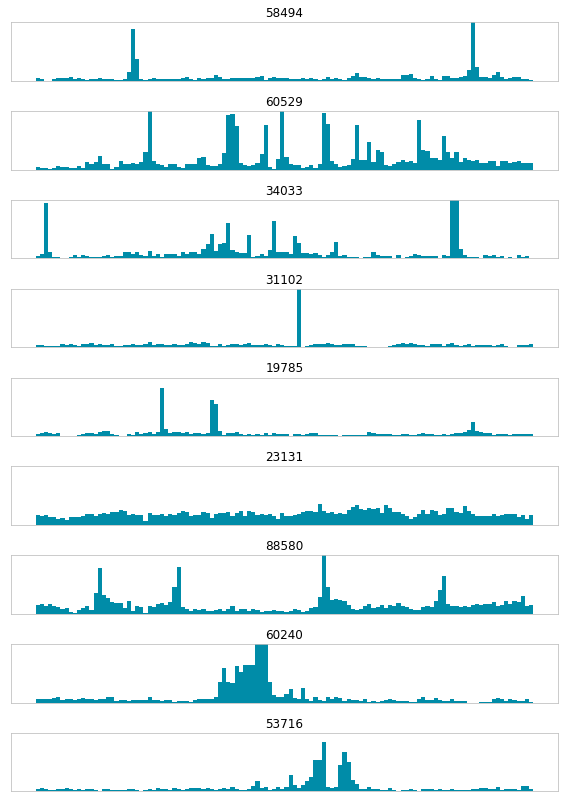

In [79]:
plot_windows_from_data(data_120kb, window_ids=targets_120kb)

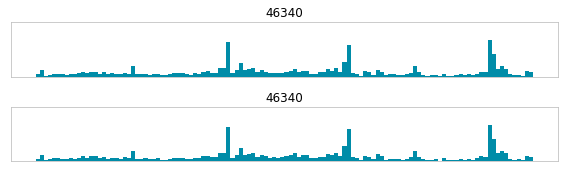

In [365]:
plot_windows_from_data(data_120kb, window_ids=[targets_120kb_ex, targets_120kb_ex])

In [105]:
from time import time

k_120kb = 20

knn_ae_120kb_new = []
knn_eq_120kb_new = []
knn_dtw_120kb_new = []
knn_umap_120kb_new = []
knn_sax_120kb_new = []
knn_tsfresh_120kb_new = []
top_xcorr_120kb_new = []

with h5py.File('data/tsfresh_120kb.h5', 'r') as f:
    tsfresh_120kb = f['features'][:]
    
    for target in targets_120kb_new:
        t0 = time()
        print('Search for window #{}'.format(target), end='', flush=True)
        knn_ae_120kb_new.append(knn(latent_120kb, target, k_120kb, ignore=1))
        print('.', end='', flush=True)
        knn_eq_120kb_new.append(knn(data_120kb, target, k_120kb, ignore=1))
        print('.', end='', flush=True)
        knn_sax_120kb_new.append(knn(sax_data_120kb, target, k_120kb, sax=sax_120kb, ignore=1))
        print('.', end='', flush=True)
        knn_umap_120kb_new.append(knn(umap_embedding_120kb, target, k_120kb, ignore=1))
        print('.', end='', flush=True)
        top_xcorr_120kb_new.append(xcorrelation(data_120kb, target, k_120kb, normalize=True, zero_normalize=True, ignore=1))
        print('.', end='', flush=True)
        knn_tsfresh_120kb_new.append(knn(tsfresh_120kb, target, k_120kb))
        print('.', end='', flush=True)
        knn_dtw_120kb_new.append(pooled_dtw(data_120kb, target, k_120kb, ignore=1))
        print('. done! ({:.2f} sec)'.format(time() - t0))

Search for window #69049....... done! (1066.05 sec)
Search for window #59132....... done! (1027.67 sec)


In [100]:
import umap

umap_embedding_120kb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
    n_components=10,
).fit_transform(data_120kb)

from tslearn.piecewise import SymbolicAggregateApproximation

sax_120kb = SymbolicAggregateApproximation(n_segments=120, alphabet_size_avg=10)
sax_data_120kb = sax_120kb.fit_transform(data_120kb)

In [ ]:
import h5py
import pandas as pd
from tsfresh import extract_features

N = data_120kb.shape[0]
L = data_120kb.shape[1]

tsfresh_120kb_df = pd.DataFrame(
    np.concatenate(
        (
            np.repeat(np.arange(data_120kb.shape[0]), data_120kb.shape[1]).reshape((-1, 1)),
            data_120kb.reshape((-1, 1)) 
        ),
        axis=1
    ),
    columns=['id', 'value']
)
batch_size = 1000

# with h5py.File('data/tsfresh_120kb.h5', 'w') as f:
#     f.create_dataset('features', shape=(N, 794), dtype=np.float32)
    
#     for i in np.arange(0, N, batch_size):
#         batch = extract_features(
#             tsfresh_120kb_df[i * L:(i + batch_size) * L],
#             column_id='id',
#             n_jobs=4,
#         ).values

#         f['features'][i:i + batch_size] = batch

In [17]:
knn_tsfresh_120kb = []

with h5py.File('data/tsfresh_120kb.h5', 'r') as f:
    tsfresh_120kb = f['features'][:]
    
    # Some features do not seem to computable. Lets set them to zero
    tsfresh_120kb[np.isnan(tsfresh_120kb)] = 0.0

In [43]:
from ae.utils import predict

prediction_120kb, _, latent_120kb = predict(
    encoder_120kb,
    decoder_120kb,
    data_120kb.reshape(data_120kb.shape[0], data_120kb.shape[1], 1)
)

In [471]:
import h5py
from time import time

knn_ae_120kb = []
knn_eq_120kb = []
knn_dtw_120kb = []
knn_umap_120kb = []
knn_sax_120kb = []
top_xcorr_120kb = []
knn_tsfresh_120kb = []

with h5py.File('data/120kb-similarity-search.h5', 'w') as f:
    f.create_dataset('targets', data=targets_120kb, dtype=np.int)

    unknown = np.ones(len(targets_120kb, k_120kb)).astype(np.int) * -1

    f.create_dataset('knn_ae', data=unknown, dtype=np.int)
    f.create_dataset('knn_eq', data=unknown, dtype=np.int)
    f.create_dataset('knn_sax', data=unknown, dtype=np.int)
    f.create_dataset('knn_dtw', data=unknown, dtype=np.int)
    f.create_dataset('knn_umap', data=unknown, dtype=np.int)
    f.create_dataset('knn_tsfresh', data=unknown, dtype=np.int)
    f.create_dataset('top_xcorr', data=unknown, dtype=np.int)
    
    with h5py.File('data/tsfresh_120kb.h5', 'r') as g:
        tsfresh_120kb = g['features'][:]

        for target in targets_120kb:
            t0 = time()
            print('Search for window #{}'.format(target), end='', flush=True)
            knn_ae_120kb.append(knn(latent_120kb, target, k_120kb, ignore=1))
            print('.', end='', flush=True)
            knn_eq_120kb.append(knn(data_120kb, target, k_120kb, ignore=1))
            print('.', end='', flush=True)
            knn_sax_120kb.append(knn(sax_data_120kb, target, k_120kb, sax=sax_120kb, ignore=1))
            print('.', end='', flush=True)
            knn_umap_120kb.append(knn(umap_embedding_120kb, target, k_120kb, ignore=1))
            print('.', end='', flush=True)
            top_xcorr_120kb.append(xcorrelation(data_120kb, target, k_120kb, normalize=True, zero_normalize=True, ignore=1))
            print('.', end='', flush=True)
            knn_tsfresh_120kb.append(knn(tsfresh_120kb, target, k_120kb, ignore=1))
            print('.', end='', flush=True)
            knn_dtw_120kb.append(pooled_dtw(data_120kb, target, k_120kb, ignore=1))
            print('. done! ({:.2f} sec)'.format(time() - t0))

Search for window #58494...... done! (1099.42 sec)
Search for window #60529...... done! (1070.17 sec)
Search for window #34033...... done! (1164.34 sec)
Search for window #31102...... done! (1089.96 sec)
Search for window #19785...... done! (1068.24 sec)
Search for window #23131...... done! (983.11 sec)
Search for window #88580...... done! (1041.86 sec)
Search for window #60240...... done! (1008.80 sec)
Search for window #53716...... done! (1032.31 sec)


In [21]:
import json

knn_120kb = {
    "targets": targets_120kb,
    "knnAe": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_ae_120kb],
    "knnEq": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_eq_120kb],
    "knnSax": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_sax_120kb],
    "knnDtw": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_dtw_120kb],
    "knnUmap": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_umap_120kb],
    "topXCorr": [x.tolist() if hasattr(x, 'tolist') else x for x in top_xcorr_120kb],
    "knnTsfresh": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_tsfresh_120kb],
}

with open('data/knn_120kb_new.json', 'w') as f:
    json.dump(knn_120kb, f)

In [71]:
import h5py

with h5py.File('data/120kb-similarity-search.h5', 'w') as f:
    f.create_dataset('targets', data=targets_120kb, dtype=np.int)
    f.create_dataset('knn_ae', data=knn_ae_120kb, dtype=np.int)
    f.create_dataset('knn_eq', data=knn_eq_120kb, dtype=np.int)
    f.create_dataset('knn_sax', data=knn_sax_120kb, dtype=np.int)
    f.create_dataset('knn_dtw', data=knn_dtw_120kb, dtype=np.int)
    f.create_dataset('knn_umap', data=knn_umap_120kb, dtype=np.int)
    f.create_dataset('knn_tsfresh', data=knn_tsfresh_120kb, dtype=np.int)
    f.create_dataset('top_xcorr', data=top_xcorr_120kb, dtype=np.int)

In [6]:
import h5py

with h5py.File('data/120kb-similarity-search.h5', 'r') as f:
    targets_120kb = f['targets'][:]
    knn_ae_120kb = f['knn_ae'][:]
    knn_eq_120kb = f['knn_eq'][:]
    knn_sax_120kb = f['knn_sax'][:]
    knn_dtw_120kb = f['knn_dtw'][:]
    top_xcorr_120kb = f['top_xcorr'][:]
    knn_umap_120kb = f['knn_umap'][:]
    knn_tsfresh_120kb = f['knn_tsfresh'][:]

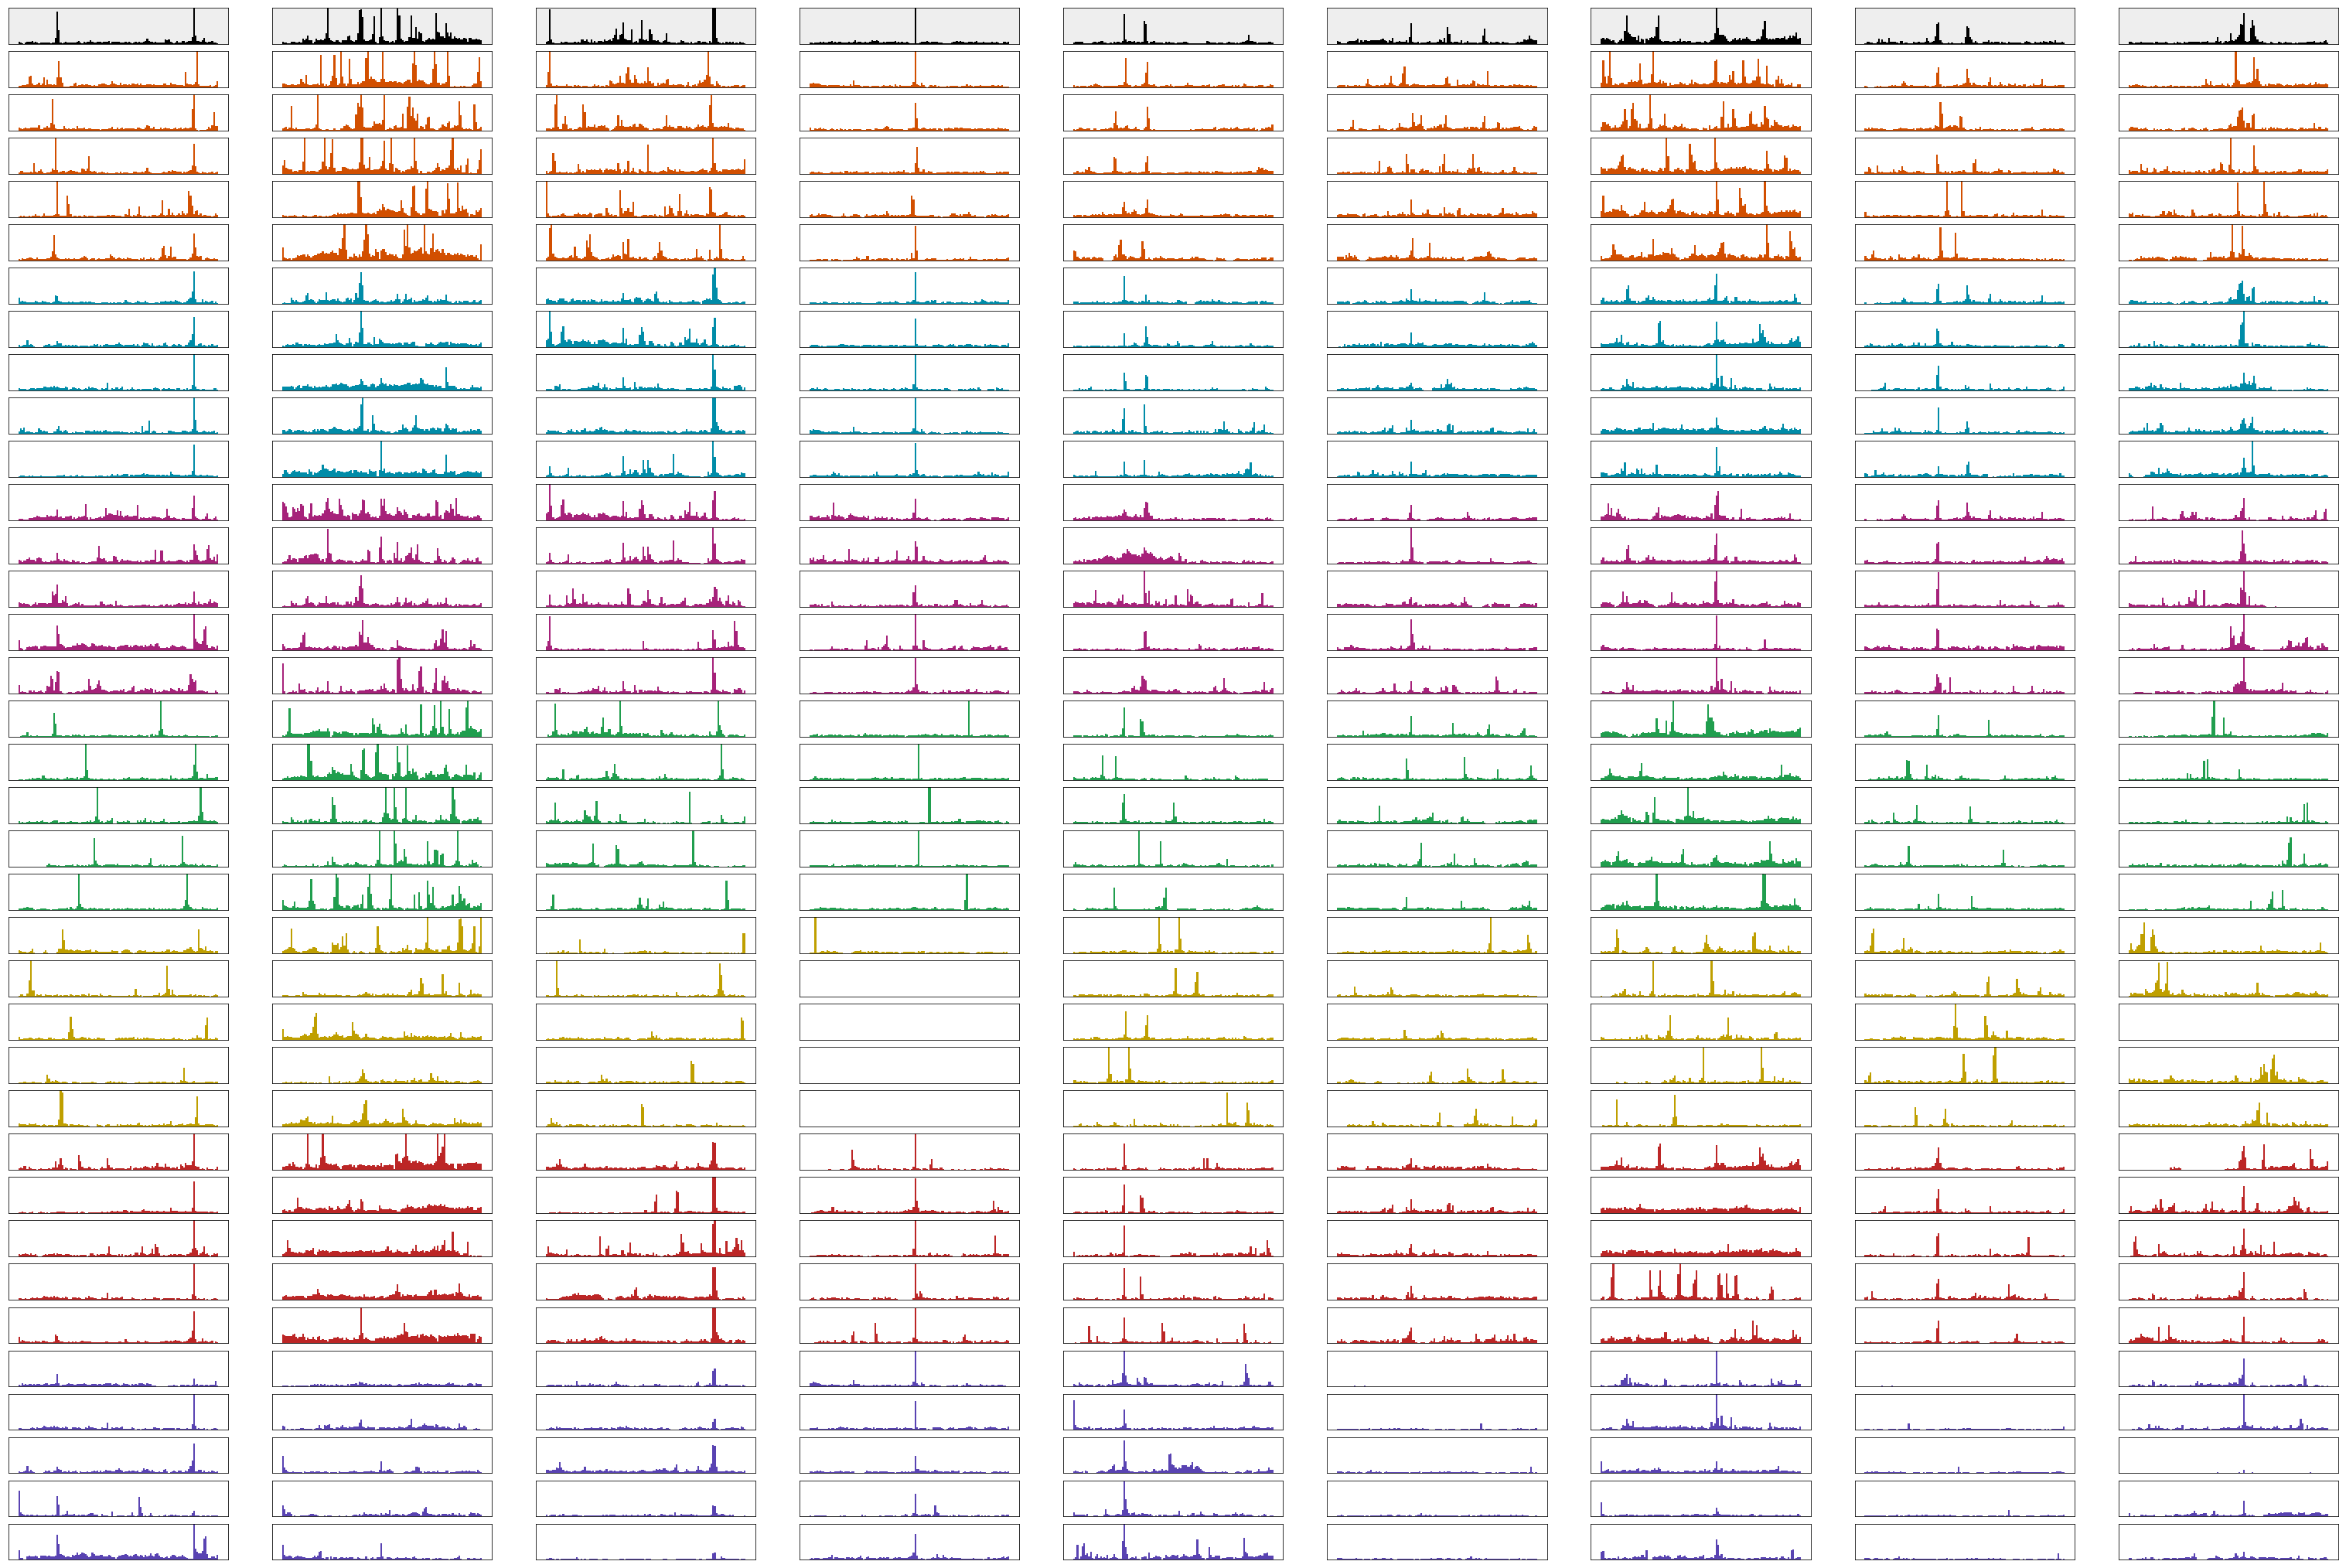

In [274]:
import matplotlib.pyplot as plt 
import numpy as np
import json

show = 5

N = (show + 1) * 7

T = len(targets_120kb)
sz = data_120kb[0].size

plt.figure(figsize=(6 * T, N))

ymax = 1.0

show_predictions = False

for i, target in enumerate(targets_120kb):
    ax = plt.subplot(N, T, (i + 1))
        
    ax.set_facecolor("#D9FAFF")
    ax.set_facecolor("#eeeeee")
    
    plt.bar(np.arange(sz), data_120kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_ae_120kb[i][:show]):
        plt.subplot(N, T, ((j + 1) * T) + (i + 1))
        plt.bar(np.arange(sz), data_120kb[hit], color='#d24f00', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(knn_eq_120kb[i][:show]):
        plt.subplot(N, T, ((j + 6) * T) + (i + 1))
        plt.bar(np.arange(sz), data_120kb[hit], color='#008ca8', width=1.0) # blue = EQ
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_sax_120kb[i][:show]):
        plt.subplot(N, T, ((j + 11) * T) + (i + 1))
        plt.bar(np.arange(sz), data_120kb[hit], color='#a6227a', width=1.0) # purple = SAX
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_dtw_120kb[i][:show]):
        plt.subplot(N, T, ((j + 16) * T) + (i + 1))
        plt.bar(np.arange(sz), data_120kb[hit], color='#209e4e', width=1.0) # green = DTW
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(top_xcorr_120kb[i][:show]):
        plt.subplot(N, T, ((j + 21) * T) + (i + 1))
        plt.bar(np.arange(sz), data_120kb[hit], color='#bf9f00', width=1.0) # yellow = Zero-nornalized X correlation
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_umap_120kb[i][:show]):
        plt.subplot(N, T, ((j + 26) * T) + (i + 1))
        plt.bar(np.arange(sz), data_120kb[hit], color='#bc2626', width=1.0) # red = UMAP
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_tsfresh_120kb[i][:show]):
        plt.subplot(N, T, ((j + 31) * T) + (i + 1))
        plt.bar(np.arange(sz), data_120kb[hit], color='#5943b2', width=1.0) # purple = tsfresh
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

### Investigate bad results for `targets_120kb[5]`

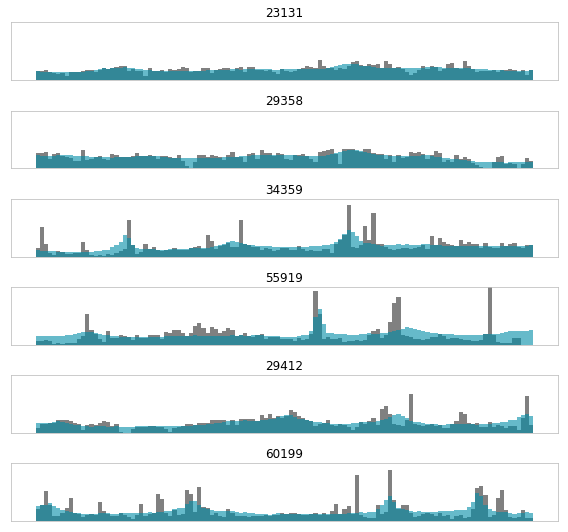

In [486]:
plot_windows_from_data(data_120kb, window_ids=[targets_120kb[5]] + knn_ae_120kb[5], predictions=prediction_120kb.squeeze(axis=2))

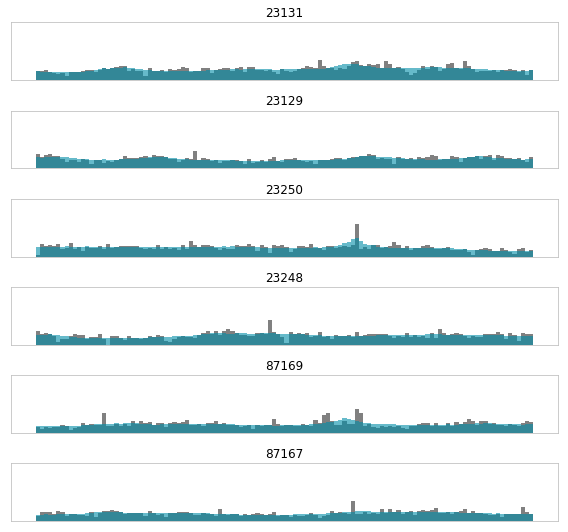

In [487]:
plot_windows_from_data(data_120kb, window_ids=[targets_120kb[5]] + knn_eq_120kb[5], predictions=prediction_120kb.squeeze(axis=2))

In [489]:
lsq = prediction_120kb.squeeze(axis=2)

target = lsq[targets_120kb[5]]
ae_res = lsq[knn_ae_120kb[5]]
eq_res = lsq[knn_eq_120kb[5]]

print(
    np.linalg.norm(ae_res - target, axis=1),
    np.linalg.norm(eq_res - target, axis=1)
)

target = latent_120kb[targets_120kb[5]]
ae_res = latent_120kb[knn_ae_120kb[5]]
eq_res = latent_120kb[knn_eq_120kb[5]]

print(
    np.linalg.norm(ae_res - target, axis=1),
    np.linalg.norm(eq_res - target, axis=1)
)

[0.47666243 0.49363893 0.72821474 0.6960579  0.90577424] [0.5082595  0.5256614  0.5445947  0.48768842 0.6327421 ]
[1.2837118 1.6142247 1.6302044 1.8720876 1.8745261] [ 6.0107164  7.58878    6.604329   7.8758965 10.795996 ]


Interestingly the distance of the reconstructed windows from EQ are closer to the original search query, i.e., the autoencoder does successfully reconstruction the windows and their distance **but** distance in the latent space does not represent this. Maybe the latent space cannot always be used out of the box

---
---
---

# 3 kb Search

In [11]:
from ae.utils import get_models
from server import bigwig

bw = 'data/ENCFF158GBQ.bigWig'

data_3kb = bigwig.chunk(
    bw,
    3000,
    25,
    3000 / 3,
    ['chr15', 'chr16'],
    verbose=True,
)

Extracted 102530 windows from chr15 with a max value of 1.0.
Extracted 90353 windows from chr16 with a max value of 1.0.


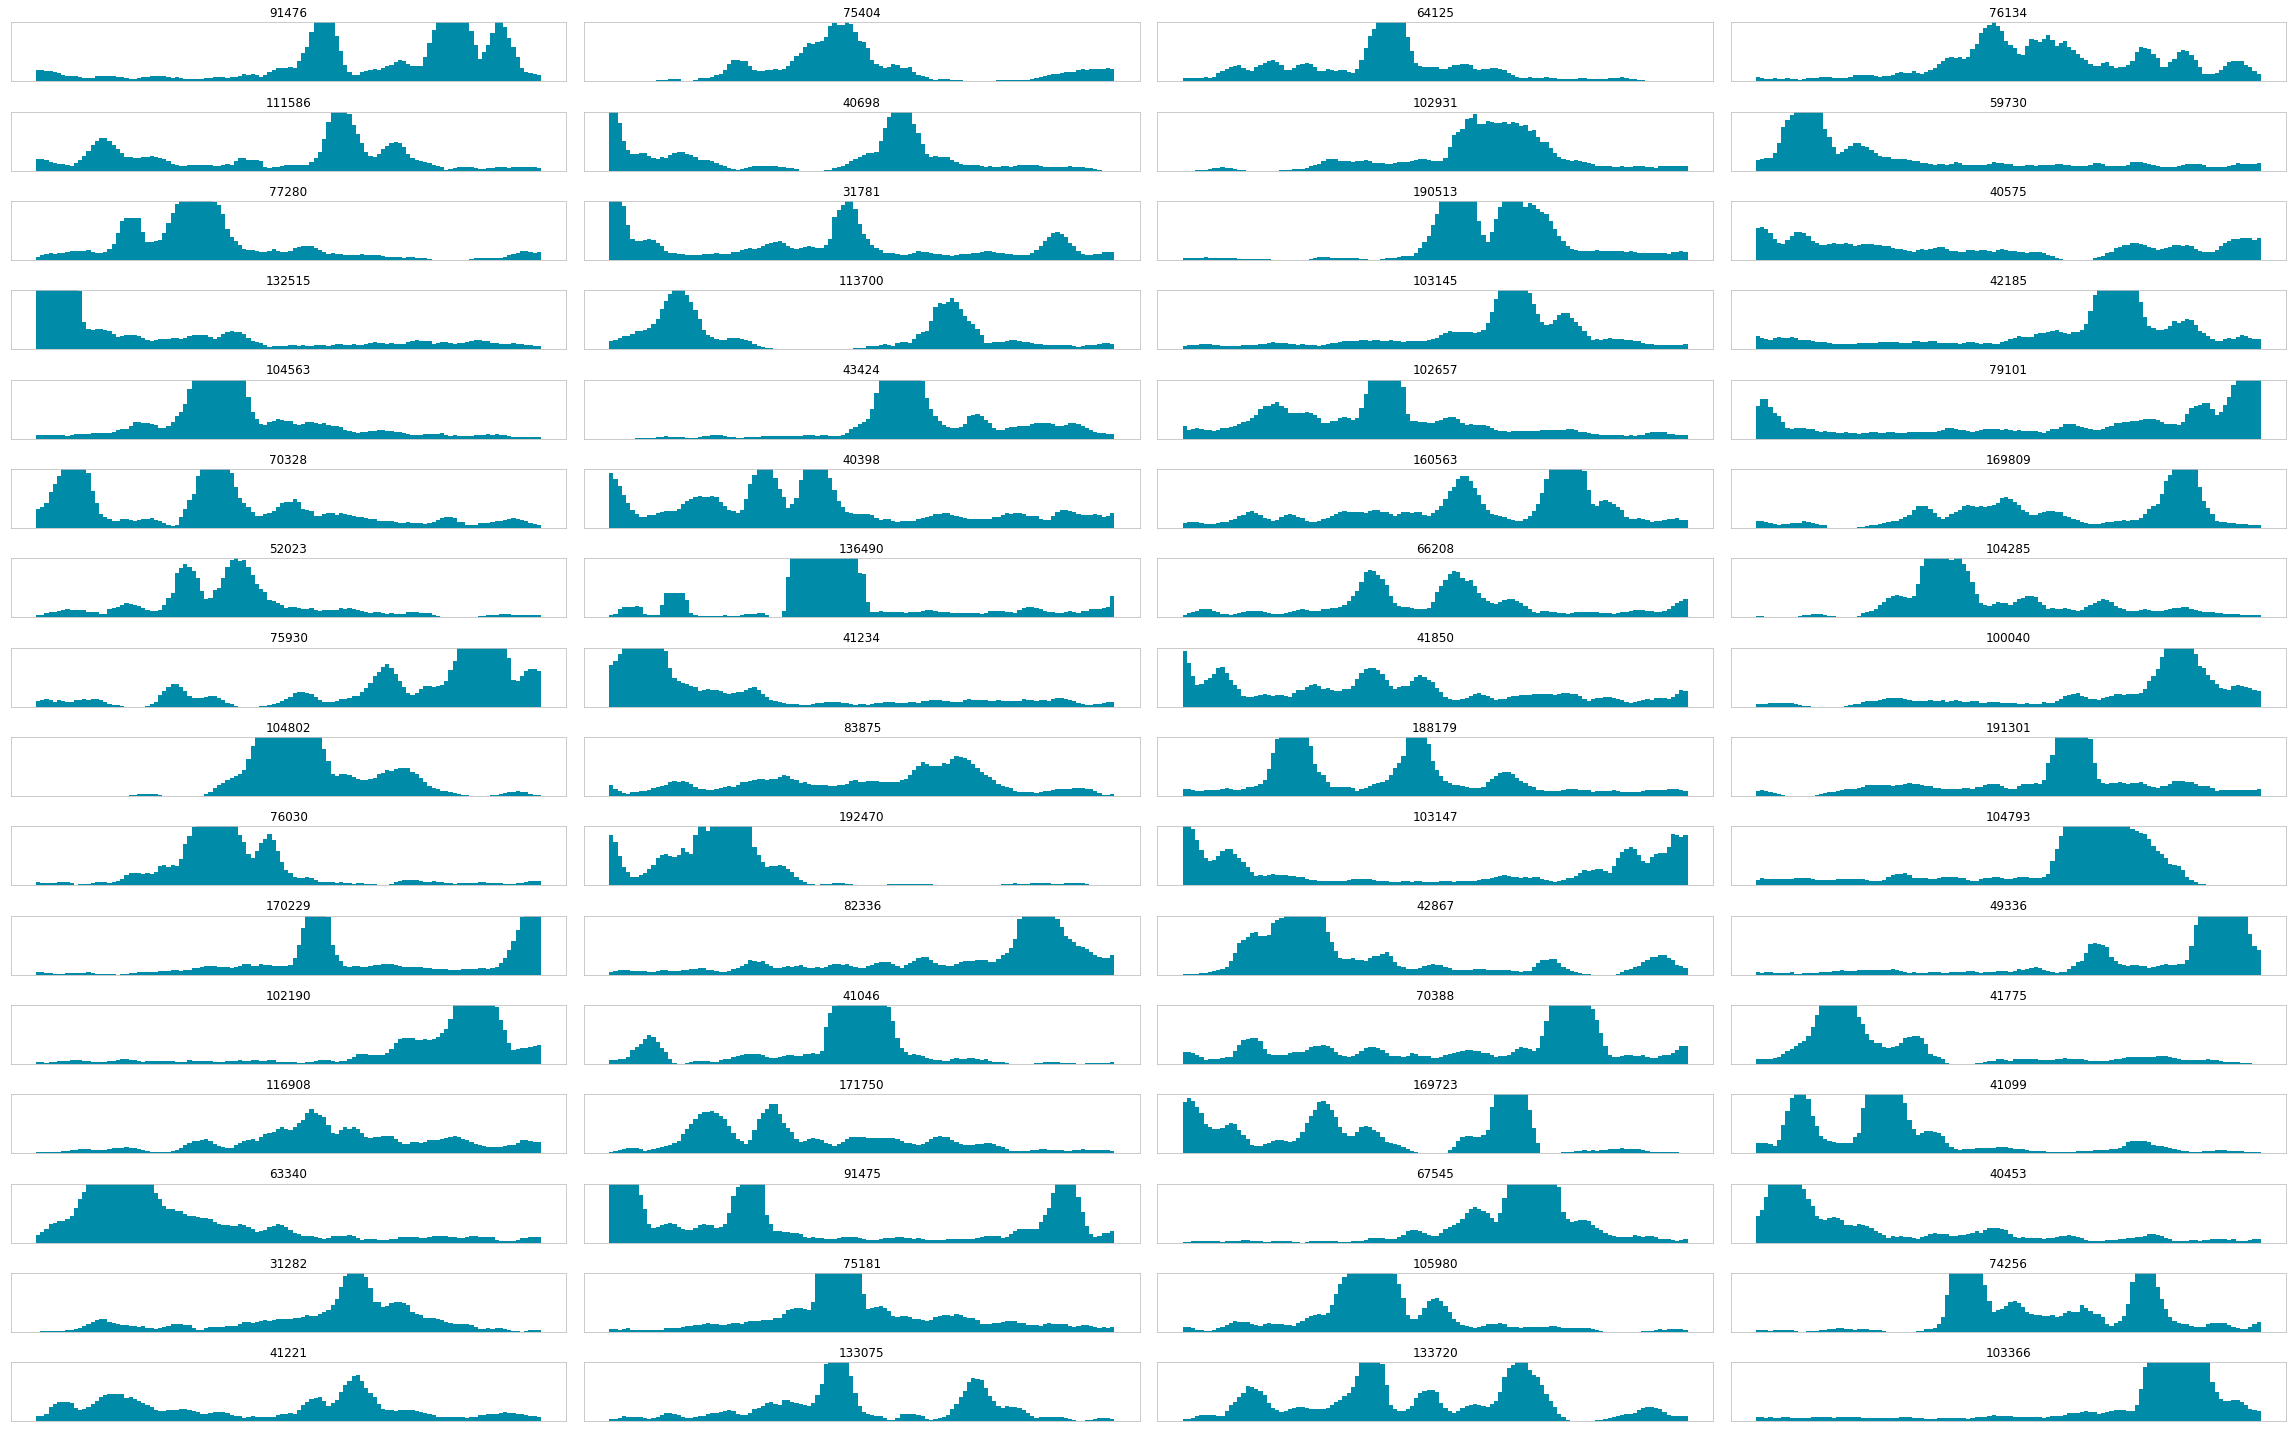

In [39]:
from ae.utils import plot_windows_from_data

plot_windows_from_data(
    data_3kb,
    num=64,
    min_signal=25,
)

In [13]:
targets_3kb = [59224, 85200, 133443, 113566, 55610, 75931, 91140, 40762, 133720]
targets_3kb_ex = 133075

# Lets store 20 but display only 5 later on
k_3kb = 20

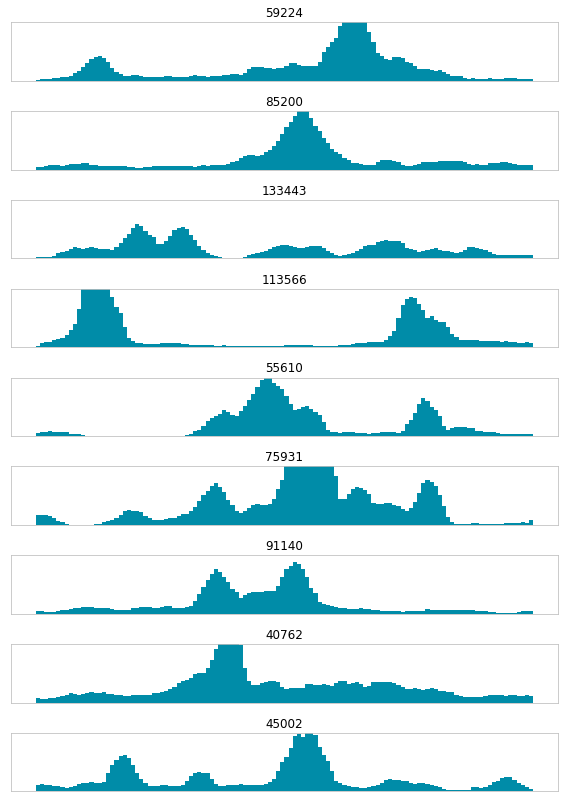

In [36]:
plot_windows_from_data(data_3kb, window_ids=targets_3kb)

In [61]:
import umap

umap_embedding_3kb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
    n_components=10,
).fit_transform(data_3kb)

from tslearn.piecewise import SymbolicAggregateApproximation

sax_3kb = SymbolicAggregateApproximation(n_segments=120, alphabet_size_avg=10)
sax_data_3kb = sax_3kb.fit_transform(data_3kb)

In [ ]:
import h5py
import pandas as pd
from tsfresh import extract_features

N = data_3kb.shape[0]
L = data_3kb.shape[1]

tsfresh_3kb_df = pd.DataFrame(
    np.concatenate(
        (
            np.repeat(np.arange(data_3kb.shape[0]), data_3kb.shape[1]).reshape((-1, 1)),
            data_3kb.reshape((-1, 1))
        ),
        axis=1
    ),
    columns=['id', 'value']
)
batch_size = 1000

# with h5py.File('data/tsfresh_3kb.h5', 'w') as f:
#     f.create_dataset('features', shape=(N, 794), dtype=np.float32)
    
#     for i in np.arange(0, N, batch_size):
#         batch = extract_features(
#             tsfresh_3kb_df[i * L:(i + batch_size) * L],
#             column_id='id',
#             n_jobs=4,
#         ).values

#         f['features'][i:i + batch_size] = batch

In [126]:
encoder_3kb, decoder_3kb, _ = get_models(
    '../../examples/models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---autoencoder-encode-dnase_w-3000_f-2_r-25.h5'
)

prediction_3kb, _, latent_3kb = predict(
    encoder_3kb,
    decoder_3kb,
    data_3kb.reshape(data_3kb.shape[0], data_3kb.shape[1], 1)
)

In [63]:
from time import time

with h5py.File('data/tsfresh_3kb.h5', 'r') as f:
    tsfresh_3kb = f['features'][:]
    
    # Some features do not seem to computable. Lets set them to zero
    tsfresh_3kb[np.isnan(tsfresh_3kb)] = 0.0
    
#     with h5py.File('data/3kb-similarity-search.h5', 'w') as f:
        f.create_dataset('knn_ae', shape=(len(targets_3kb), k_3kb), dtype=np.int)
        f.create_dataset('knn_eq', shape=(len(targets_3kb), k_3kb), dtype=np.int)
        f.create_dataset('knn_sax', shape=(len(targets_3kb), k_3kb), dtype=np.int)
        f.create_dataset('knn_dtw', shape=(len(targets_3kb), k_3kb), dtype=np.int)
        f.create_dataset('knn_umap', shape=(len(targets_3kb), k_3kb), dtype=np.int)
        f.create_dataset('knn_tsfresh', shape=(len(targets_3kb), k_3kb), dtype=np.int)
        f.create_dataset('top_xcorr', shape=(len(targets_3kb), k_3kb), dtype=np.int)

        for i, target in enumerate(targets_3kb):
            t0 = time()
            print('Search for window #{}'.format(target), end='', flush=True)
            f['knn_ae'][i] = knn(latent_3kb, target, k_3kb, ignore=1)
            print('.', end='', flush=True)
            f['knn_eq'][i] = knn(data_3kb, target, k_3kb, ignore=1)
            print('.', end='', flush=True)
            f['knn_sax'][i] = knn(sax_data_3kb, target, k_3kb, sax=sax_3kb, ignore=1)
            print('.', end='', flush=True)
            f['knn_umap'][i] = knn(umap_embedding_3kb, target, k_3kb, ignore=1)
            print('.', end='', flush=True)
            f['top_xcorr'][i] = xcorrelation(
                data_3kb, target, k_3kb, normalize=True, zero_normalize=True, ignore=1
            )
            print('.', end='', flush=True)
            f['knn_tsfresh'][i] = knn(tsfresh_3kb, target, k_3kb, ignore=1)
            print('.', end='', flush=True)
            f['knn_dtw'][i] = pooled_dtw(data_3kb, target, k_3kb, ignore=1)
            print('. done! ({:.2f} sec)'.format(time() - t0))

Search for window #59224....... done! (1989.70 sec)
Search for window #85200....... done! (1975.76 sec)
Search for window #133443....... done! (2020.69 sec)
Search for window #113566....... done! (1989.02 sec)
Search for window #55610....... done! (2066.95 sec)
Search for window #75931....... done! (2061.27 sec)
Search for window #91140....... done! (2012.11 sec)
Search for window #40762....... done! (1976.63 sec)
Search for window #45002....... done! (1999.57 sec)


In [32]:
with h5py.File('data/3kb-similarity-search.h5', 'r') as f:
    targets_3kb = f['targets'][:]
    knn_ae_3kb = f['knn_ae'][:]
    knn_eq_3kb = f['knn_eq'][:]
    knn_sax_3kb = f['knn_sax'][:]
    knn_dtw_3kb = f['knn_dtw'][:]
    top_xcorr_3kb = f['top_xcorr'][:]
    knn_umap_3kb = f['knn_umap'][:]
    knn_tsfresh_3kb = f['knn_tsfresh'][:]

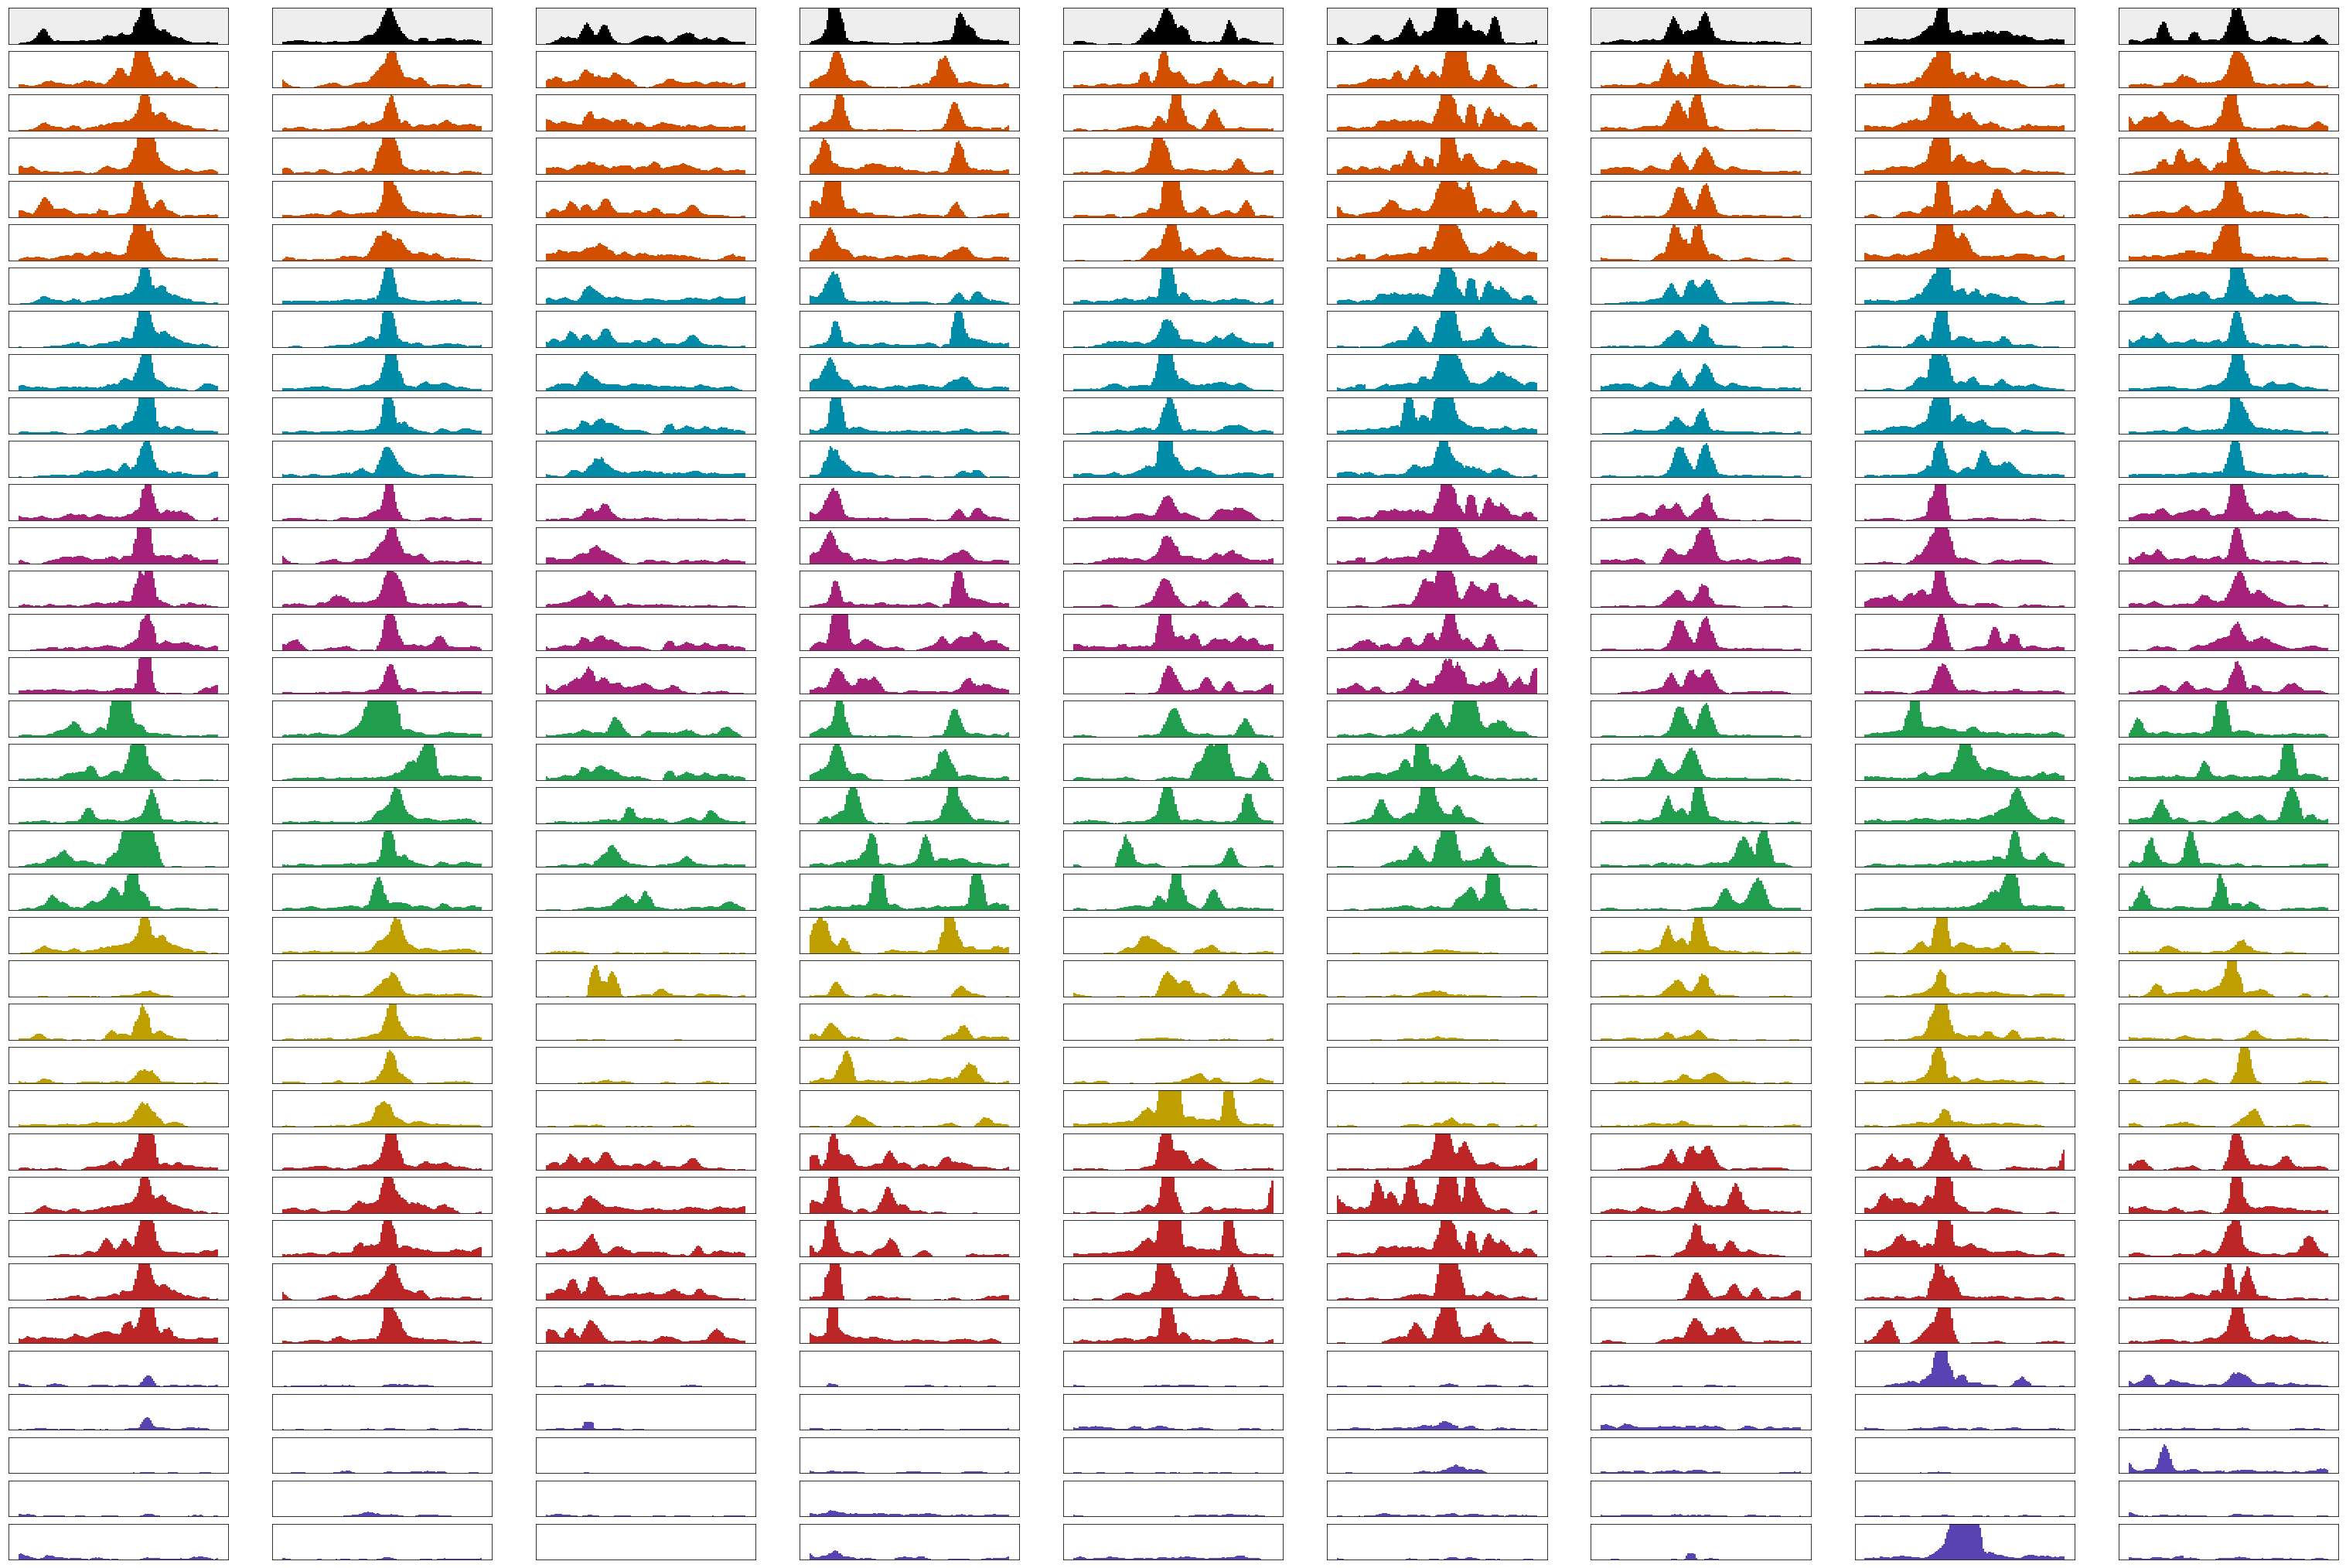

In [33]:
import matplotlib.pyplot as plt 
import numpy as np
    
show = 5

N = (show + 1) * 7

T = len(targets_3kb)
sz = data_3kb[0].size

plt.figure(figsize=(6 * T, N))

ymax = 1.0

show_predictions = False

for i, target in enumerate(targets_3kb):
    ax = plt.subplot(N, T, (i + 1))
        
    ax.set_facecolor("#D9FAFF")
    ax.set_facecolor("#eeeeee")
    
    plt.bar(np.arange(sz), data_3kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_ae_3kb[i][:show]):
        plt.subplot(N, T, ((j + 1) * T) + (i + 1))
        plt.bar(np.arange(sz), data_3kb[hit], color='#d24f00', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(knn_eq_3kb[i][:show]):
        plt.subplot(N, T, ((j + 6) * T) + (i + 1))
        plt.bar(np.arange(sz), data_3kb[hit], color='#008ca8', width=1.0) # blue = PAA/ED
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_sax_3kb[i][:show]):
        plt.subplot(N, T, ((j + 11) * T) + (i + 1))
        plt.bar(np.arange(sz), data_3kb[hit], color='#a6227a', width=1.0) # purple = SAX
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_dtw_3kb[i][:show]):
        plt.subplot(N, T, ((j + 16) * T) + (i + 1))
        plt.bar(np.arange(sz), data_3kb[hit], color='#209e4e', width=1.0) # green = DTW
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(top_xcorr_3kb[i][:show]):
        plt.subplot(N, T, ((j + 21) * T) + (i + 1))
        plt.bar(np.arange(sz), data_3kb[hit], color='#bf9f00', width=1.0) # yellow = Zero-nornalized X correlation
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])[:k_3kb]

    for j, hit in enumerate(knn_umap_3kb[i][:show]):
        plt.subplot(N, T, ((j + 26) * T) + (i + 1))
        plt.bar(np.arange(sz), data_3kb[hit], color='#bc2626', width=1.0) # red = UMAP
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_tsfresh_3kb[i][:show]):
        plt.subplot(N, T, ((j + 31) * T) + (i + 1))
        plt.bar(np.arange(sz), data_3kb[hit], color='#5943b2', width=1.0) # purple = tsfresh
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

---
---
---

# Individual Plots For MTurk

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

show = 5

sz = data_12kb[0].size

ymax = 1.0

width = 3
height = 0.625

query_color = '#000000'
query_bg_color = '#ffffff'
knn_color = '#004c80'
knn_bg_color = '#ebf2f5'


resolutions = ['3KB', '12KB', '120KB']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
targets = {
    '3KB': targets_3kb,
    '12KB': targets_12kb,
    '120KB': targets_120kb
}
data = {
    '3KB': data_3kb,
    '12KB': data_12kb,
    '120KB': data_120kb
}
knns = {
    '3KB': [
        knn_ae_3kb,
        knn_eq_3kb,
        knn_sax_3kb,
        knn_dtw_3kb,
        knn_umap_3kb,
        knn_tsfresh_3kb,
        top_xcorr_3kb,
    ],
    '12KB': [
        knn_ae_12kb,
        knn_eq_12kb,
        knn_sax_12kb,
        knn_dtw_12kb,
        knn_umap_12kb,
        knn_tsfresh_12kb,
        top_xcorr_12kb,
    ],
    '120KB': [
        knn_ae_120kb,
        knn_eq_120kb,
        knn_sax_120kb,
        knn_dtw_120kb,
        knn_umap_120kb,
        knn_tsfresh_120kb,
        top_xcorr_120kb,
    ]
}

for res in resolutions:
    for t, target in enumerate(targets[res]):
        for k, knn_ in enumerate(knns[res]):
            fig, ax = plt.subplots(
                show + 2,
                figsize=(width, height * (show + 1.1)),
                sharex=True,
                gridspec_kw=dict(height_ratios=([1,0.15] + [1] * show), hspace=0)
            )

            ax[0].bar(np.arange(sz), data[res][target], color=query_color, width=1.0)
            ax[0].set_facecolor(query_bg_color)
            ax[0].spines["top"].set_color(query_color)
            ax[0].spines["right"].set_color(query_color)
            ax[0].spines["bottom"].set_color(query_color)
            ax[0].spines["left"].set_color(query_color)
            ax[0].set_ylim(0, ymax)
            ax[0].set_xticks([], [])
            ax[0].set_yticks([], [])

            ax[1].set_xticks([], [])
            ax[1].set_yticks([], [])
            ax[1].spines['top'].set_color(query_color)
            ax[1].spines['right'].set_visible(False)
            ax[1].spines['bottom'].set_visible(False)
            ax[1].spines['left'].set_visible(False)

            for j, hit in enumerate(knn_[t][:show]):
                ax[j + 2].bar(np.arange(sz), data[res][hit], color=knn_color, width=1.0)
                ax[j + 2].set_facecolor(knn_bg_color)
                ax[j + 2].spines["top"].set_color(knn_color)
                ax[j + 2].spines["right"].set_color(knn_color)
                ax[j + 2].spines["bottom"].set_color(knn_color)
                ax[j + 2].spines["left"].set_color(knn_color)
                ax[j + 2].set_ylim(0, ymax)
                ax[j + 2].set_xticks([], [])
                ax[j + 2].set_yticks([], [])

            fig.savefig('../mturk/{}-T{}{}.png'.format(res, t, labels[k]), bbox_inches="tight")


## Manually picked examples for good and not so good similarity

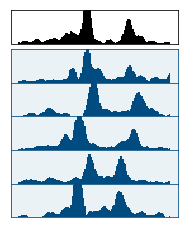

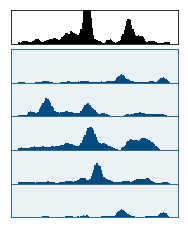

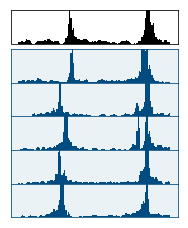

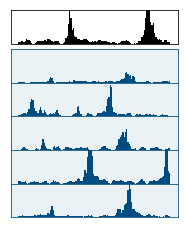

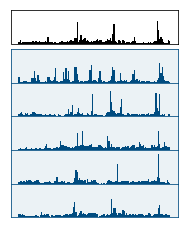

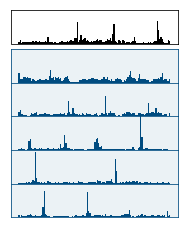

In [417]:
import matplotlib.pyplot as plt 
import numpy as np

show = 5

sz = data_12kb[0].size

ymax = 1.0

width = 3
height = 0.625

query_color = '#000000'
query_bg_color = '#ffffff'
knn_color = '#004c80'
knn_bg_color = '#ebf2f5'


resolutions = ['3KB', '12KB', '120KB']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
targets = {
    '3KB': [targets_3kb_ex],
    '12KB': [targets_12kb_ex],
    '120KB': [targets_120kb_ex]
}
data = {
    '3KB': data_3kb,
    '12KB': data_12kb,
    '120KB': data_120kb
}
knns = {
    '3KB': [
        [[184007, 65174, 105548, 38855, 79164]],
        [[113868, 74299, 129990, 58623, 113868]],
    ],
    '12KB': [
        [[54908, 77611, 3128, 80563, 17661]],
        [[56863, 113442, 16479, 523, 18194]],
    ],
    '120KB': [
        [[36277, 93818, 64712, 29190, 583]],
        [[46346, 70315, 89973, 75775, 51299]],
    ]
}

for res in resolutions:
    for t, target in enumerate(targets[res]):
        for k, knn_ in enumerate(knns[res]):
            fig, ax = plt.subplots(
                show + 2,
                figsize=(width, height * (show + 1.1)),
                sharex=True,
                gridspec_kw=dict(height_ratios=([1,0.15] + [1] * show), hspace=0)
            )

            ax[0].bar(np.arange(sz), data[res][target], color=query_color, width=1.0)
            ax[0].set_facecolor(query_bg_color)
            ax[0].spines["top"].set_color(query_color)
            ax[0].spines["right"].set_color(query_color)
            ax[0].spines["bottom"].set_color(query_color)
            ax[0].spines["left"].set_color(query_color)
            ax[0].set_ylim(0, ymax)
            ax[0].set_xticks([], [])
            ax[0].set_yticks([], [])

            ax[1].set_xticks([], [])
            ax[1].set_yticks([], [])
            ax[1].spines['top'].set_color(query_color)
            ax[1].spines['right'].set_visible(False)
            ax[1].spines['bottom'].set_visible(False)
            ax[1].spines['left'].set_visible(False)

            for j, hit in enumerate(knn_[t][:show]):
                ax[j + 2].bar(np.arange(sz), data[res][hit], color=knn_color, width=1.0)
                ax[j + 2].set_facecolor(knn_bg_color)
                ax[j + 2].spines["top"].set_color(knn_color)
                ax[j + 2].spines["right"].set_color(knn_color)
                ax[j + 2].spines["bottom"].set_color(knn_color)
                ax[j + 2].spines["left"].set_color(knn_color)
                ax[j + 2].set_ylim(0, ymax)
                ax[j + 2].set_xticks([], [])
                ax[j + 2].set_yticks([], [])

            fig.savefig('../mturk/{}-E{}{}.png'.format(res, t, labels[k]), bbox_inches="tight")


In [12]:
import h5py

with h5py.File('data/search-targets.h5', 'w') as f:
    f.create_dataset('targets_3kb', data=data_3kb[targets_3kb])
    f.create_dataset('targets_12kb', data=data_12kb[targets_12kb])
    f.create_dataset('targets_120kb', data=data_120kb[targets_120kb])

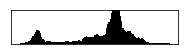

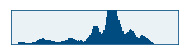

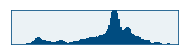

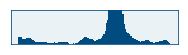

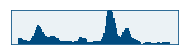

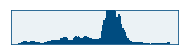

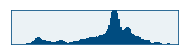

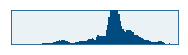

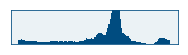

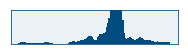

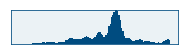

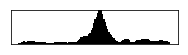

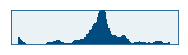

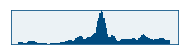

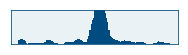

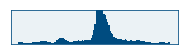

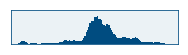

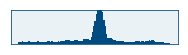

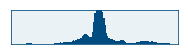

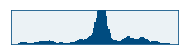

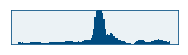

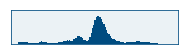

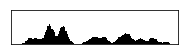

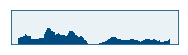

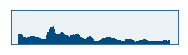

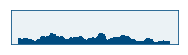

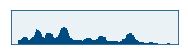

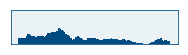

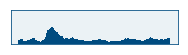

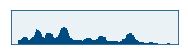

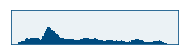

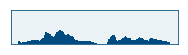

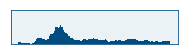

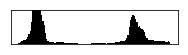

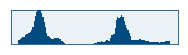

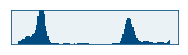

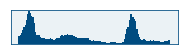

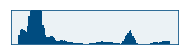

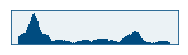

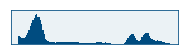

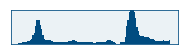

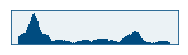

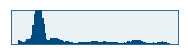

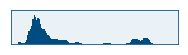

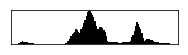

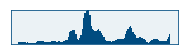

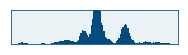

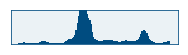

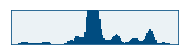

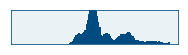

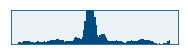

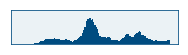

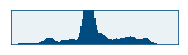

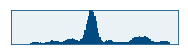

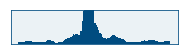

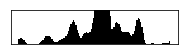

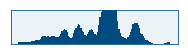

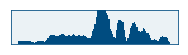

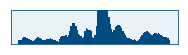

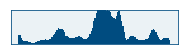

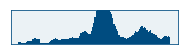

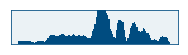

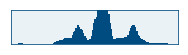

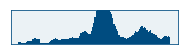

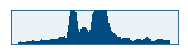

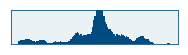

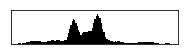

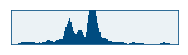

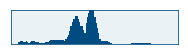

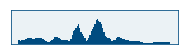

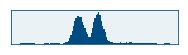

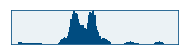

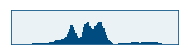

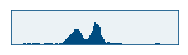

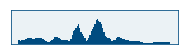

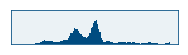

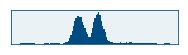

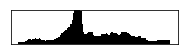

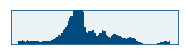

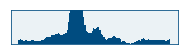

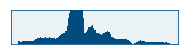

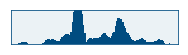

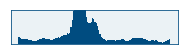

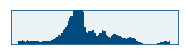

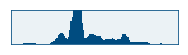

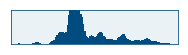

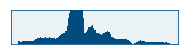

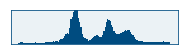

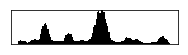

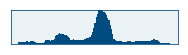

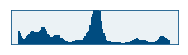

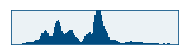

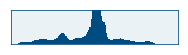

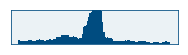

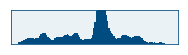

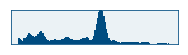

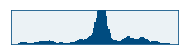

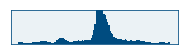

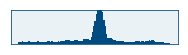

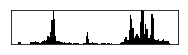

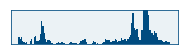

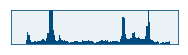

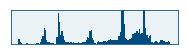

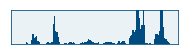

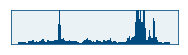

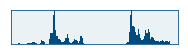

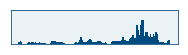

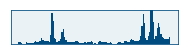

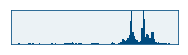

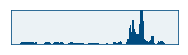

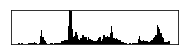

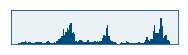

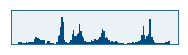

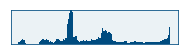

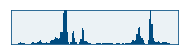

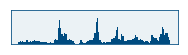

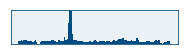

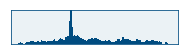

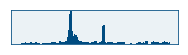

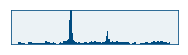

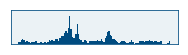

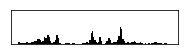

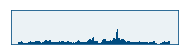

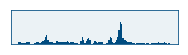

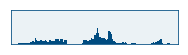

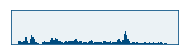

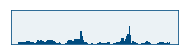

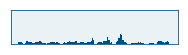

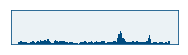

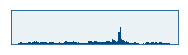

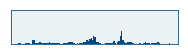

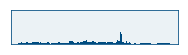

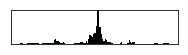

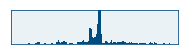

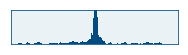

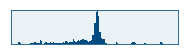

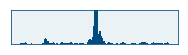

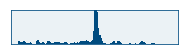

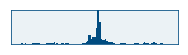

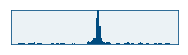

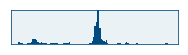

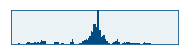

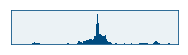

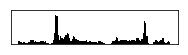

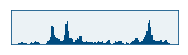

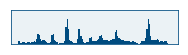

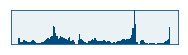

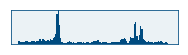

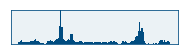

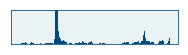

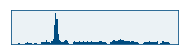

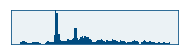

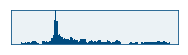

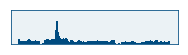

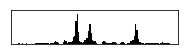

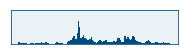

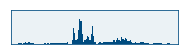

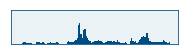

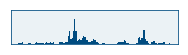

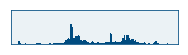

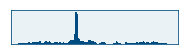

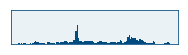

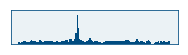

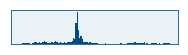

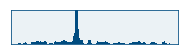

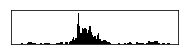

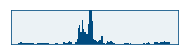

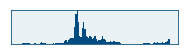

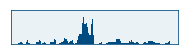

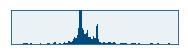

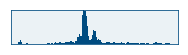

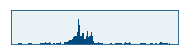

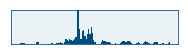

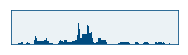

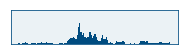

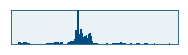

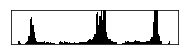

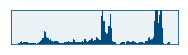

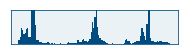

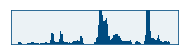

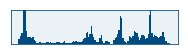

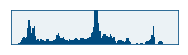

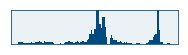

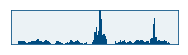

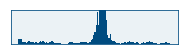

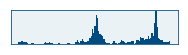

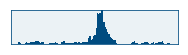

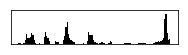

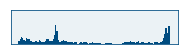

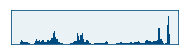

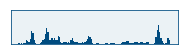

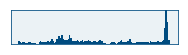

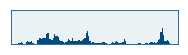

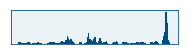

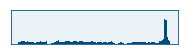

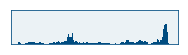

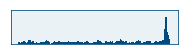

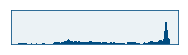

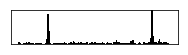

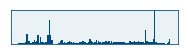

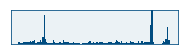

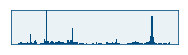

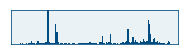

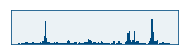

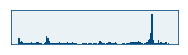

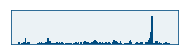

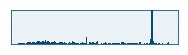

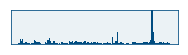

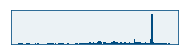

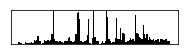

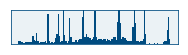

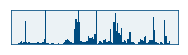

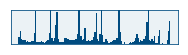

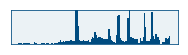

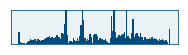

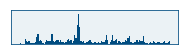

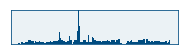

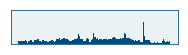

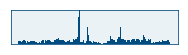

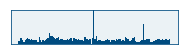

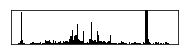

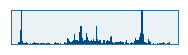

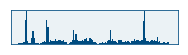

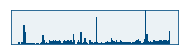

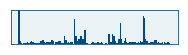

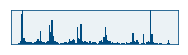

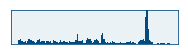

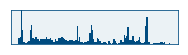

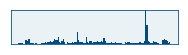

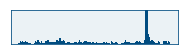

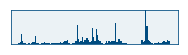

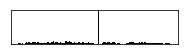

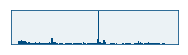

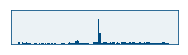

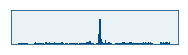

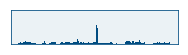

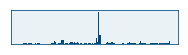

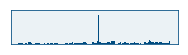

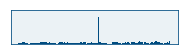

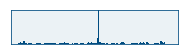

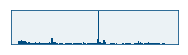

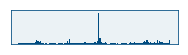

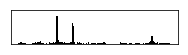

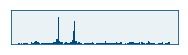

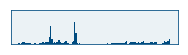

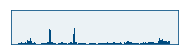

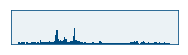

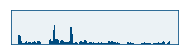

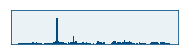

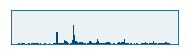

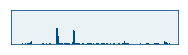

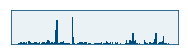

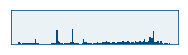

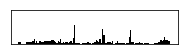

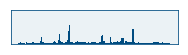

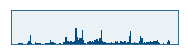

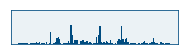

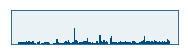

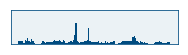

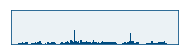

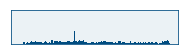

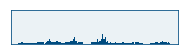

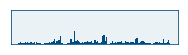

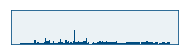

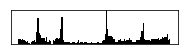

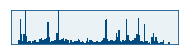

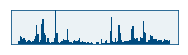

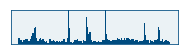

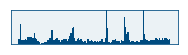

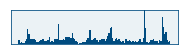

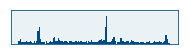

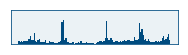

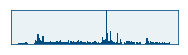

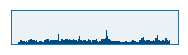

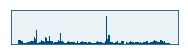

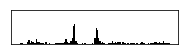

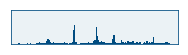

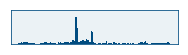

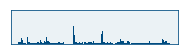

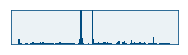

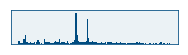

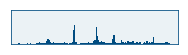

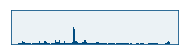

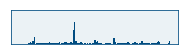

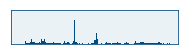

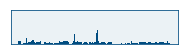

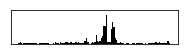

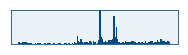

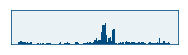

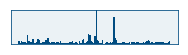

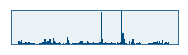

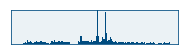

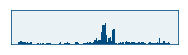

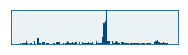

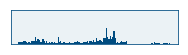

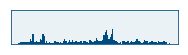

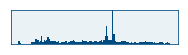

In [52]:
import matplotlib.pyplot as plt 
import numpy as np

show = 5

sz = data_12kb[0].size

ymax = 1.0

width = 3
height = 0.625

query_color = '#000000'
query_bg_color = '#ffffff'
knn_color = '#004c80'
knn_bg_color = '#ebf2f5'


resolutions = ['3KB', '12KB', '120KB']
targets = {
    '3KB': targets_3kb,
    '12KB': targets_12kb,
    '120KB': targets_120kb
}
data = {
    '3KB': data_3kb,
    '12KB': data_12kb,
    '120KB': data_120kb
}
knns = {
    '3KB': [
        knn_ae_3kb,
        knn_eq_3kb,
#         knn_dtw_3kb,
    ],
    '12KB': [
        knn_ae_12kb,
        knn_eq_12kb,
#         knn_dtw_12kb,
    ],
    '120KB': [
        knn_ae_120kb,
        knn_eq_120kb,
#         knn_dtw_120kb,
    ]
}
techniques = ['A', 'B']

for res in resolutions:
    for t, target in enumerate(targets[res]):
        plt.figure(figsize=(width, height), dpi=72)
        ax = plt.gca()

        ax.bar(np.arange(sz), data[res][target], color=query_color, width=1.0)
        ax.set_facecolor(query_bg_color)
        ax.spines["top"].set_color(query_color)
        ax.spines["right"].set_color(query_color)
        ax.spines["bottom"].set_color(query_color)
        ax.spines["left"].set_color(query_color)
        ax.set_ylim(0, 1)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
 
        plt.savefig(
            '../mturk/{}-T{}.png'.format(res, t),
            bbox_inches="tight",
            pad_inches=0
        )
    
        for k, knn_ in enumerate(knns[res]):
            for n, nn in enumerate(knn_[t][:show]):
                plt.figure(figsize=(width, height), dpi=72)
                ax = plt.gca()

                ax.bar(np.arange(sz), data[res][nn], color=knn_color, width=1.0)
                ax.set_facecolor(knn_bg_color)
                ax.spines["top"].set_color(knn_color)
                ax.spines["right"].set_color(knn_color)
                ax.spines["bottom"].set_color(knn_color)
                ax.spines["left"].set_color(knn_color)
                ax.set_ylim(0, 1)
                ax.set_xticks([], [])
                ax.set_yticks([], [])

                plt.savefig(
                    '../mturk/{}-T{}{}{}.png'.format(res, t, n, techniques[k]),
                    bbox_inches="tight",
                    pad_inches=0
                )


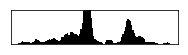

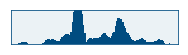

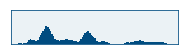

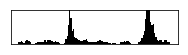

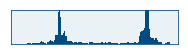

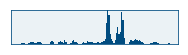

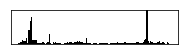

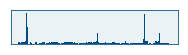

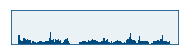

In [51]:
import matplotlib.pyplot as plt 
import numpy as np

show = 5

sz = data_12kb[0].size

ymax = 1.0

width = 3
height = 0.625

query_color = '#000000'
query_bg_color = '#ffffff'
knn_color = '#004c80'
knn_bg_color = '#ebf2f5'


resolutions = ['3KB', '12KB', '120KB']
targets = {
    '3KB': [targets_3kb_ex],
    '12KB': [targets_12kb_ex],
    '120KB': [targets_120kb_ex]
}
data = {
    '3KB': data_3kb,
    '12KB': data_12kb,
    '120KB': data_120kb
}
knns = {
    '3KB': [
        [79164],
        [74299],
    ],
    '12KB': [
        [80563],
        [4608],
    ],
    '120KB': [
        [68213],
        [46346],
    ]
}
techniques = ['A', 'B']

for res in resolutions:
    for t, target in enumerate(targets[res]):
        plt.figure(figsize=(width, height), dpi=72)
        ax = plt.gca()

        ax.bar(np.arange(sz), data[res][target], color=query_color, width=1.0)
        ax.set_facecolor(query_bg_color)
        ax.spines["top"].set_color(query_color)
        ax.spines["right"].set_color(query_color)
        ax.spines["bottom"].set_color(query_color)
        ax.spines["left"].set_color(query_color)
        ax.set_ylim(0, 1)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
 
        plt.savefig(
            '../mturk/{}-ET-2.png'.format(res, t),
            bbox_inches="tight",
            pad_inches=0
        )
    
        for k, knn_ in enumerate(knns[res]):
            for n, nn in enumerate(knn_):
                plt.figure(figsize=(width, height), dpi=72)
                ax = plt.gca()

                ax.bar(np.arange(sz), data[res][nn], color=knn_color, width=1.0)
                ax.set_facecolor(knn_bg_color)
                ax.spines["top"].set_color(knn_color)
                ax.spines["right"].set_color(knn_color)
                ax.spines["bottom"].set_color(knn_color)
                ax.spines["left"].set_color(knn_color)
                ax.set_ylim(0, 1)
                ax.set_xticks([], [])
                ax.set_yticks([], [])

                plt.savefig(
                    '../mturk/{}-E{}-2.png'.format(res, techniques[k]),
                    bbox_inches="tight",
                    pad_inches=0
                )
